[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sofiansyed/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dataset already exists at /Users/sofiansyed/.convokit/saved-corpora/gap-corpus
Download complete!


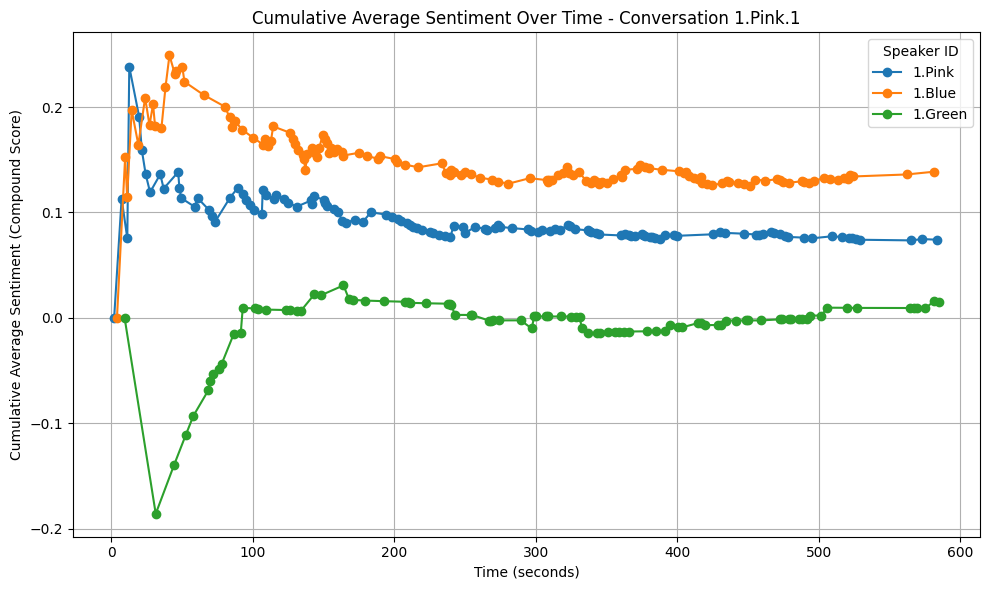

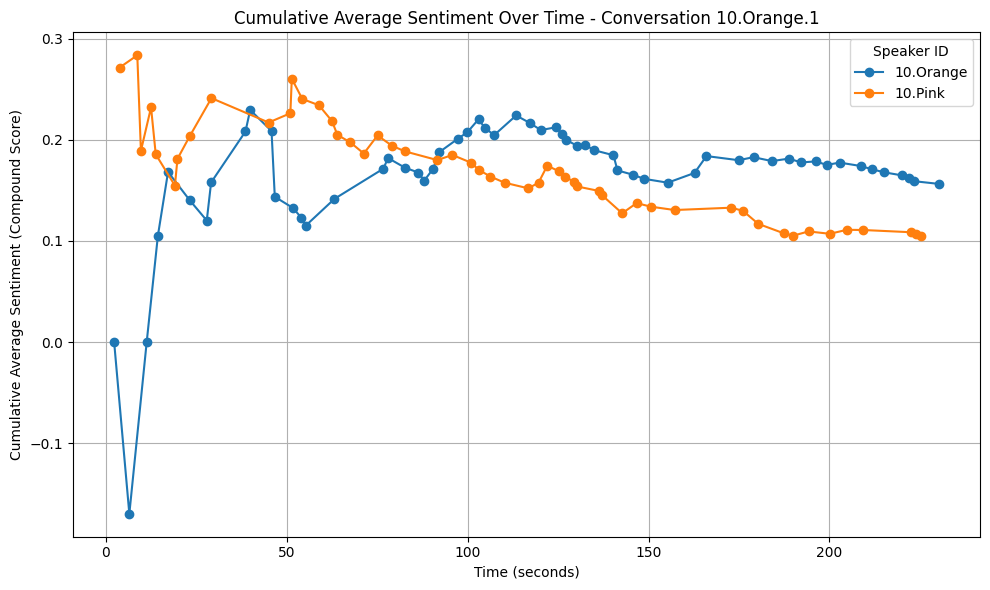

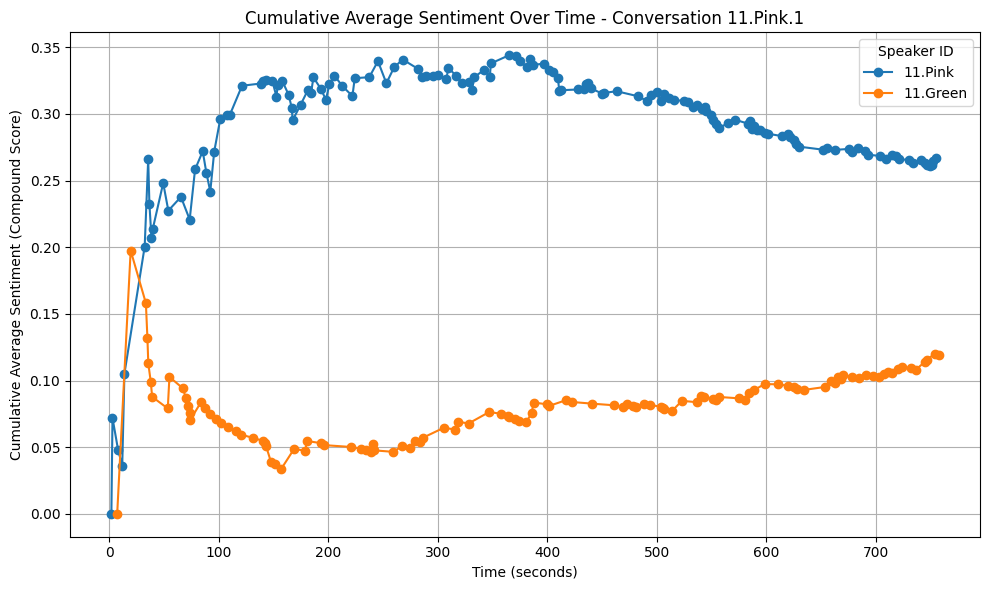

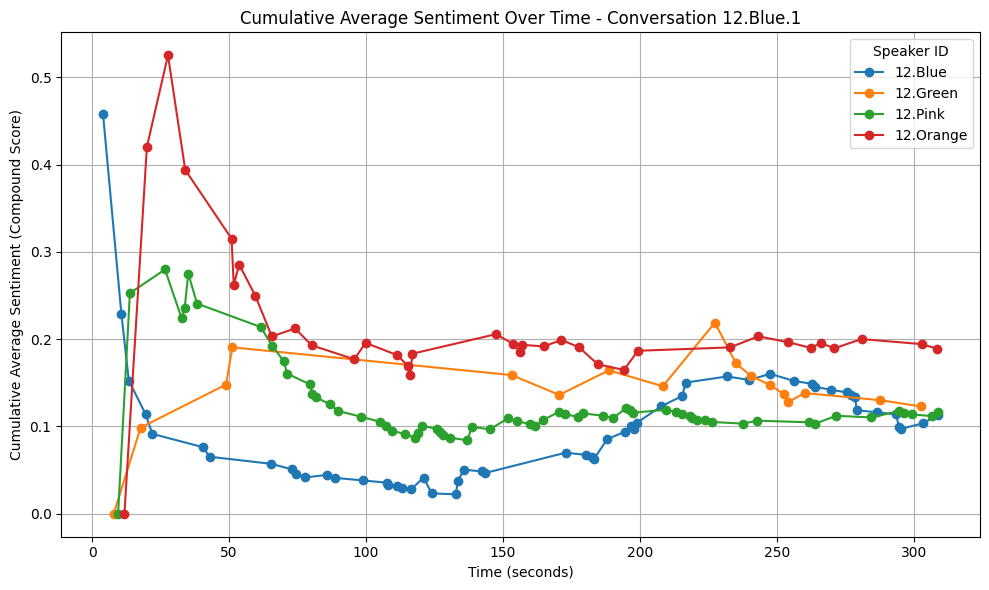

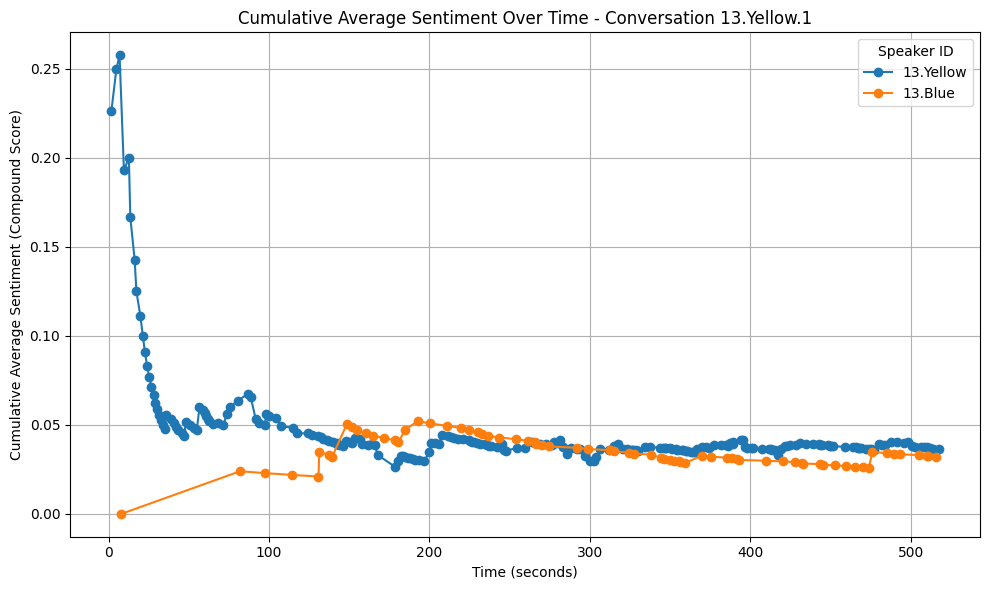

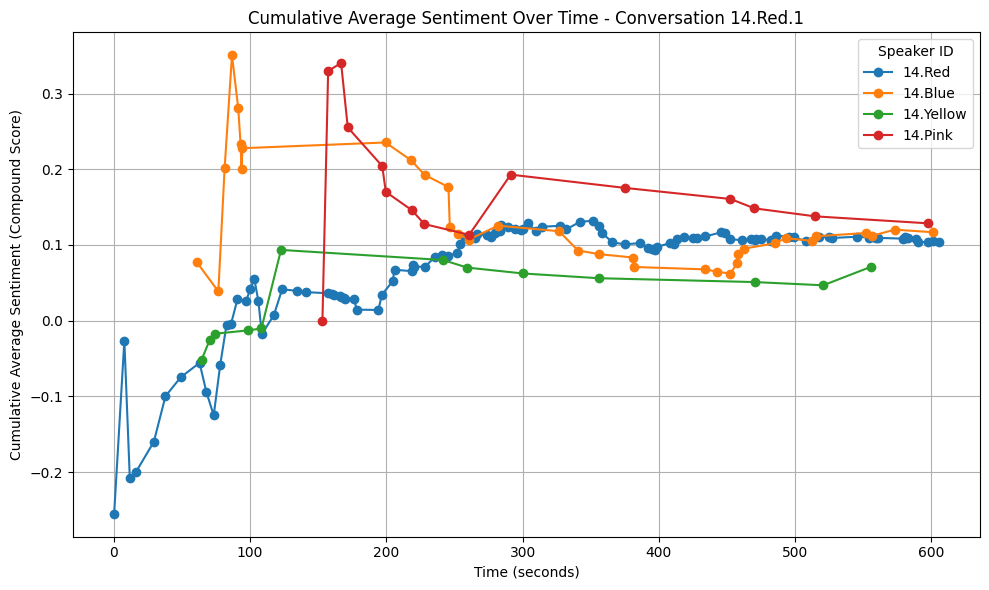

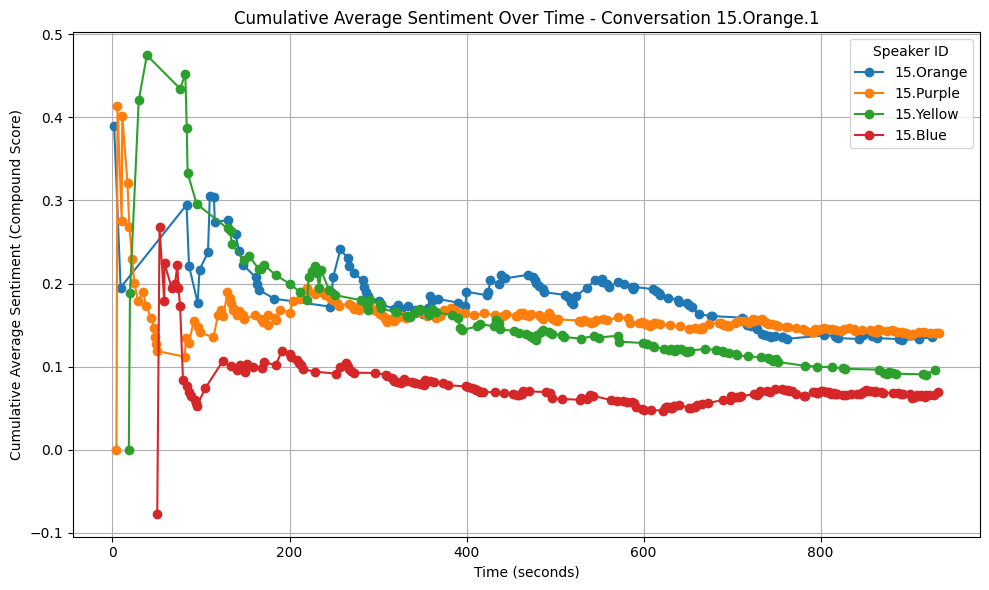

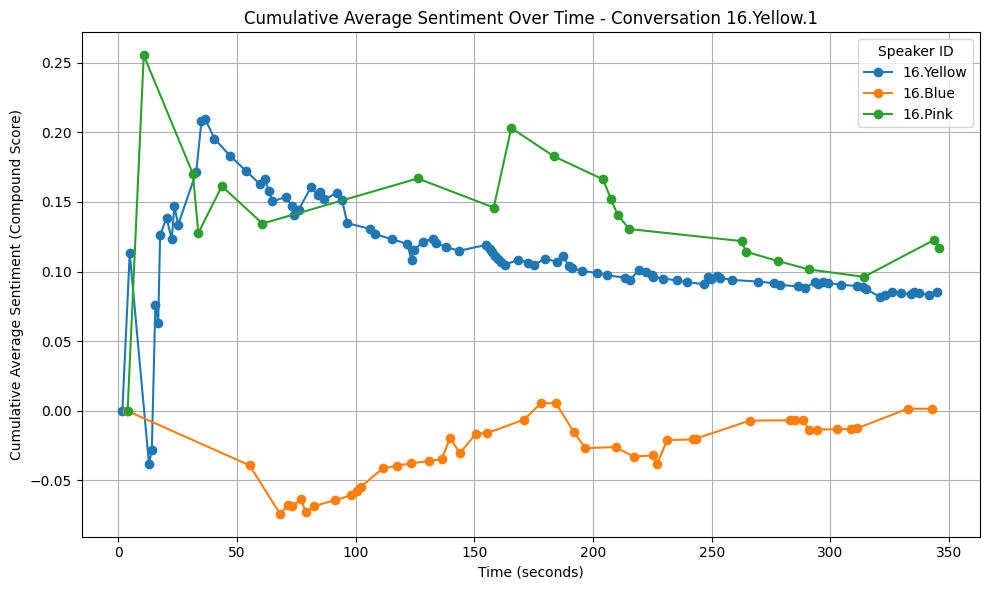

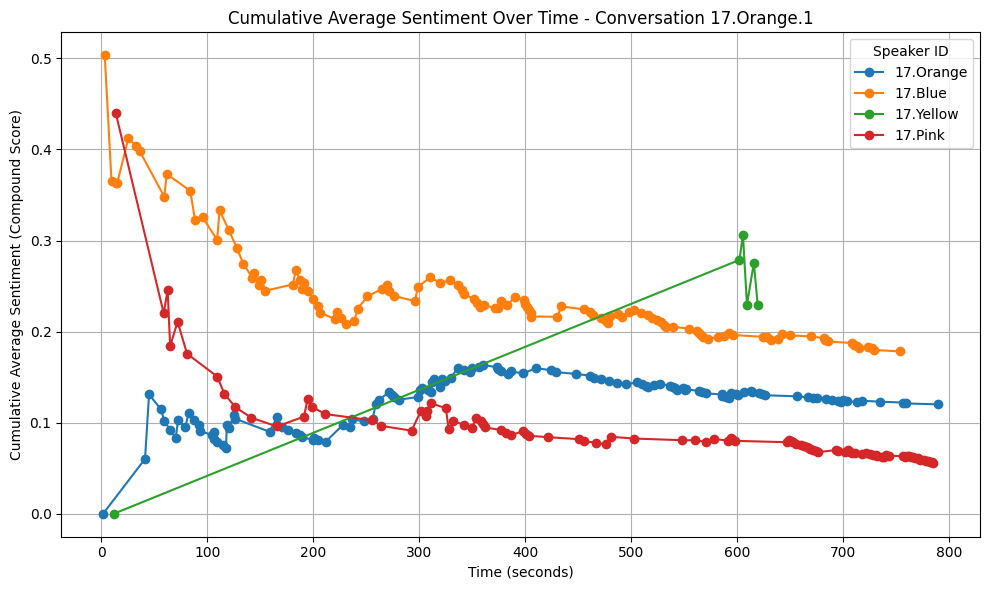

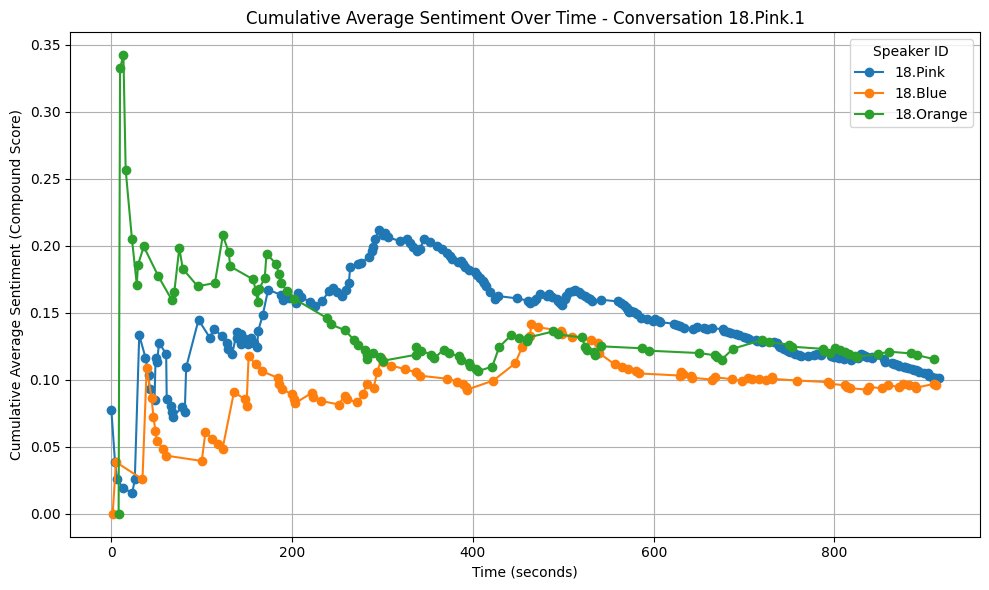

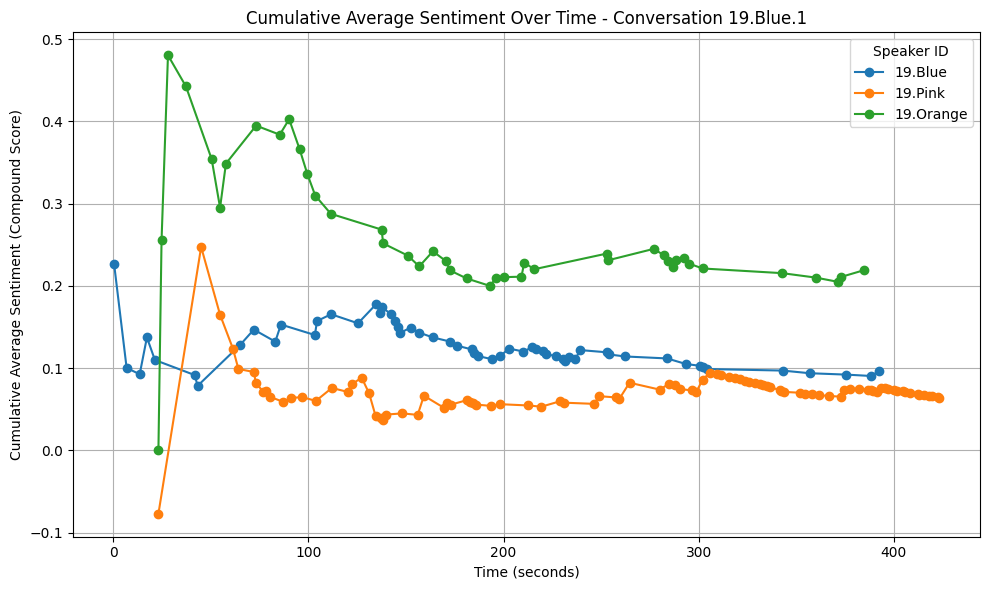

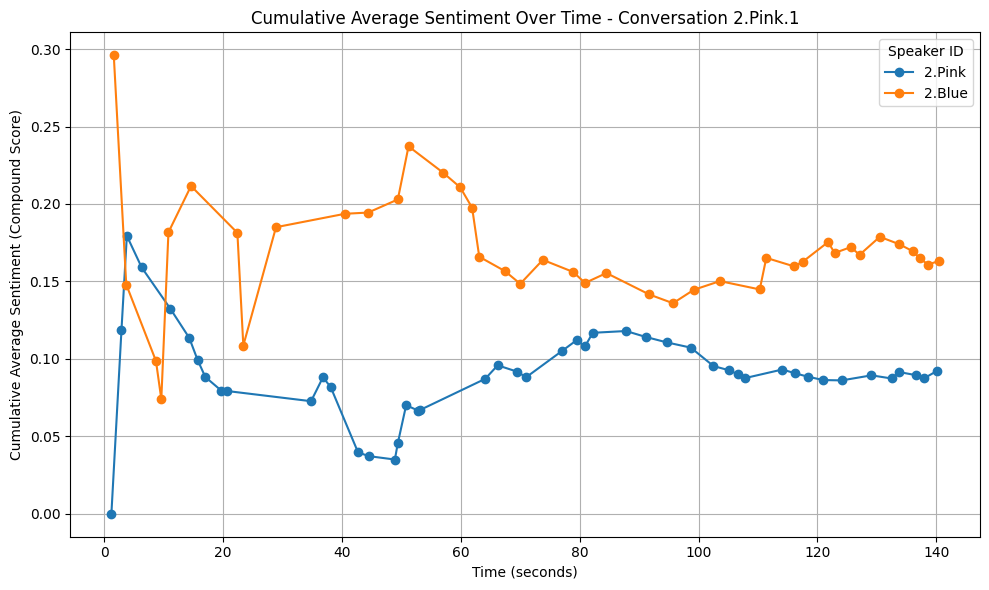

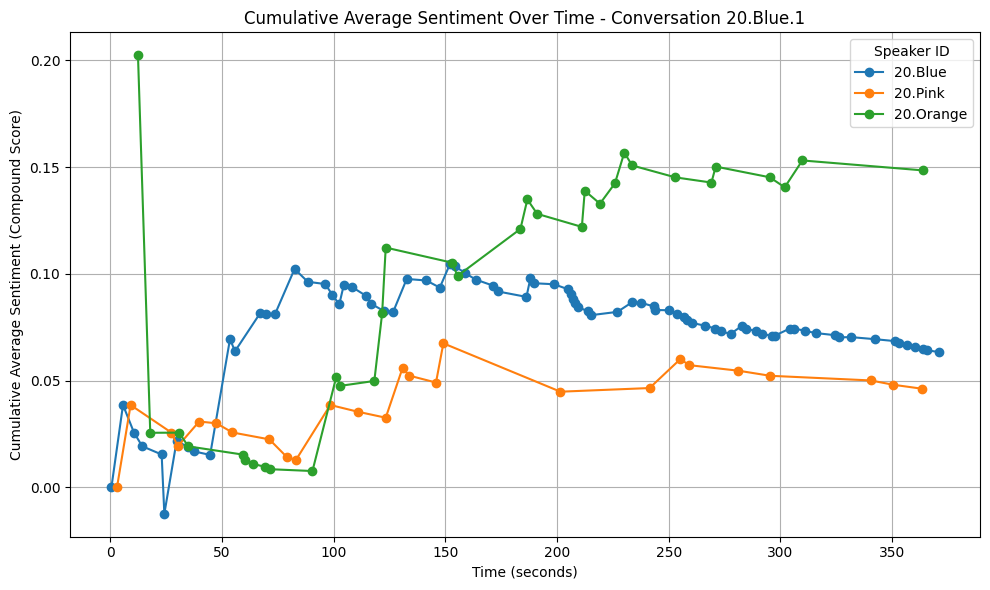

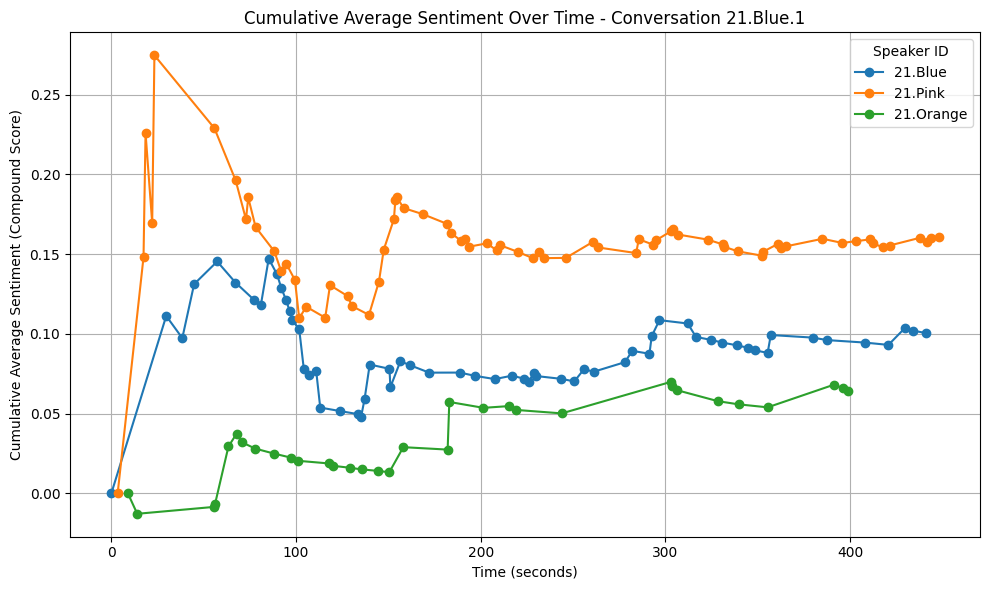

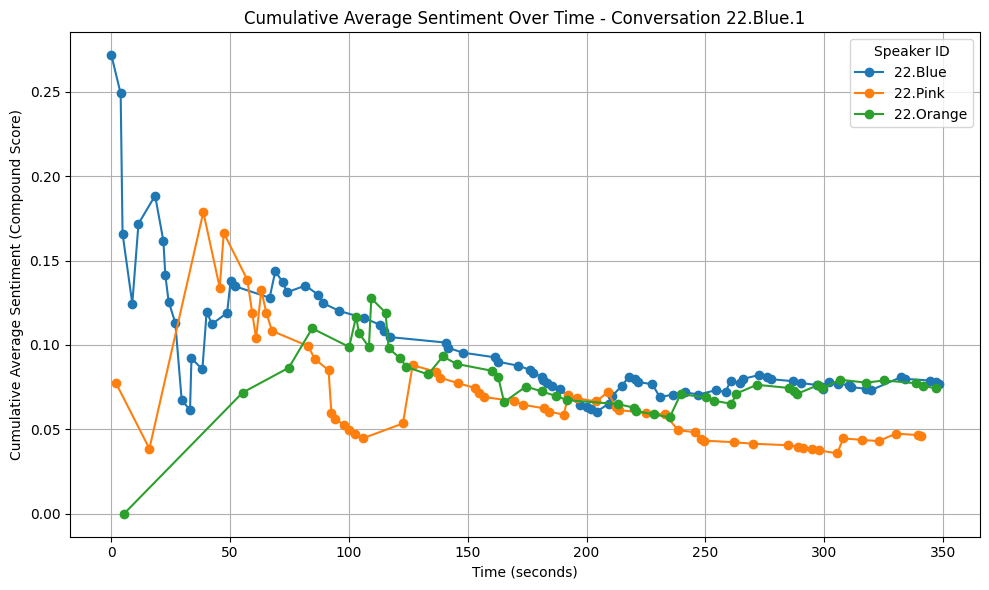

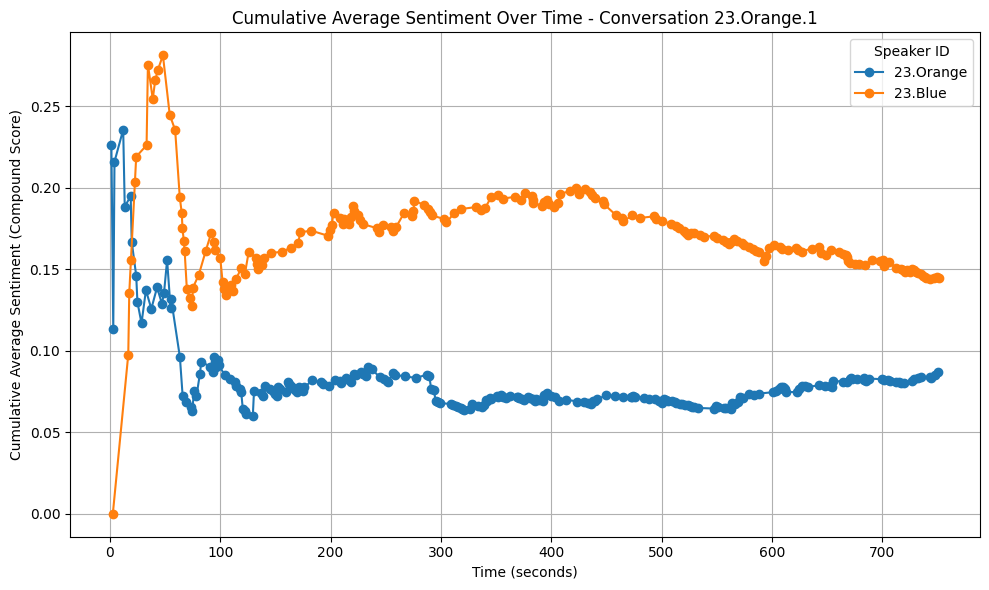

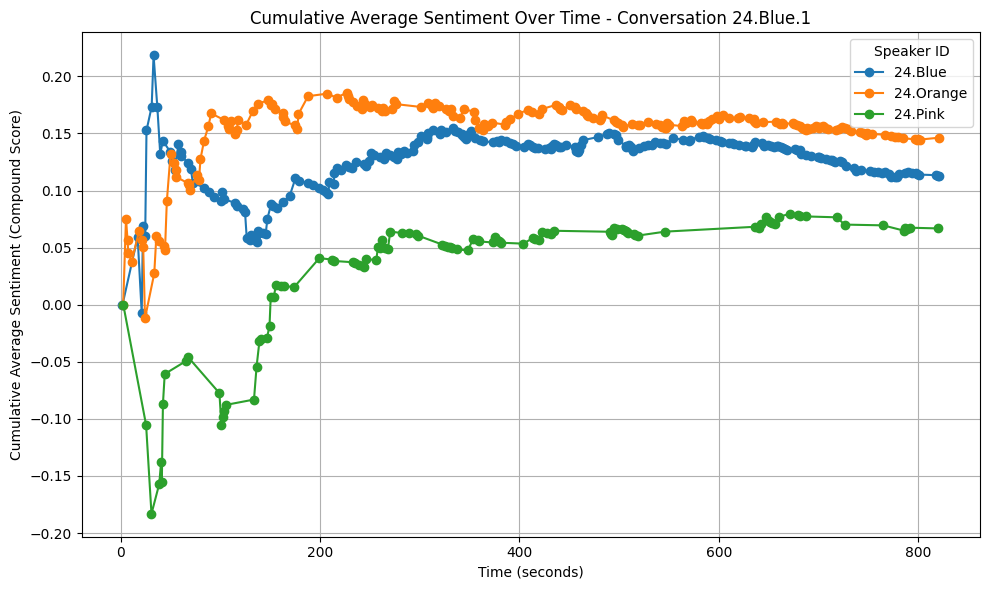

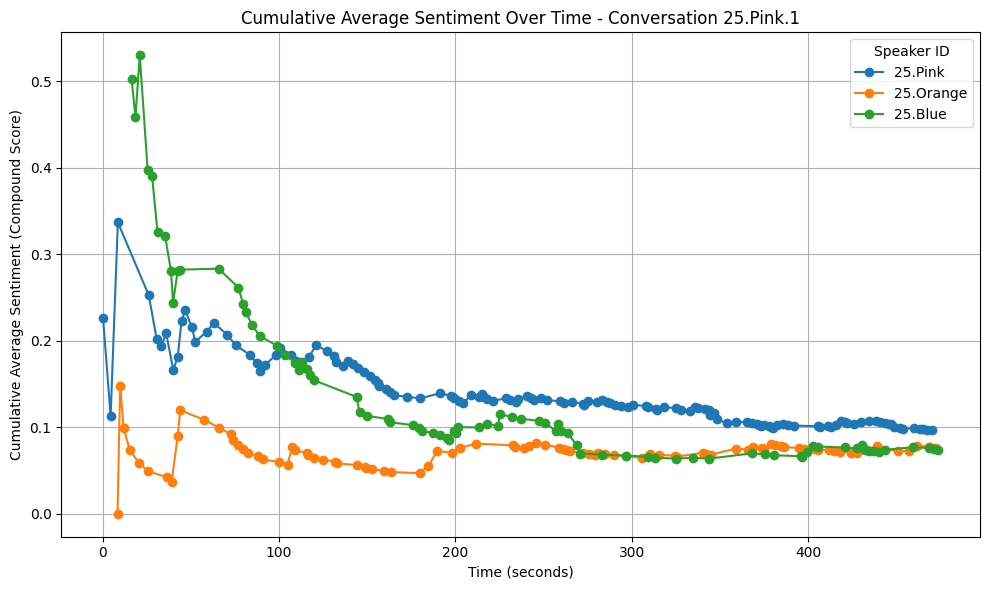

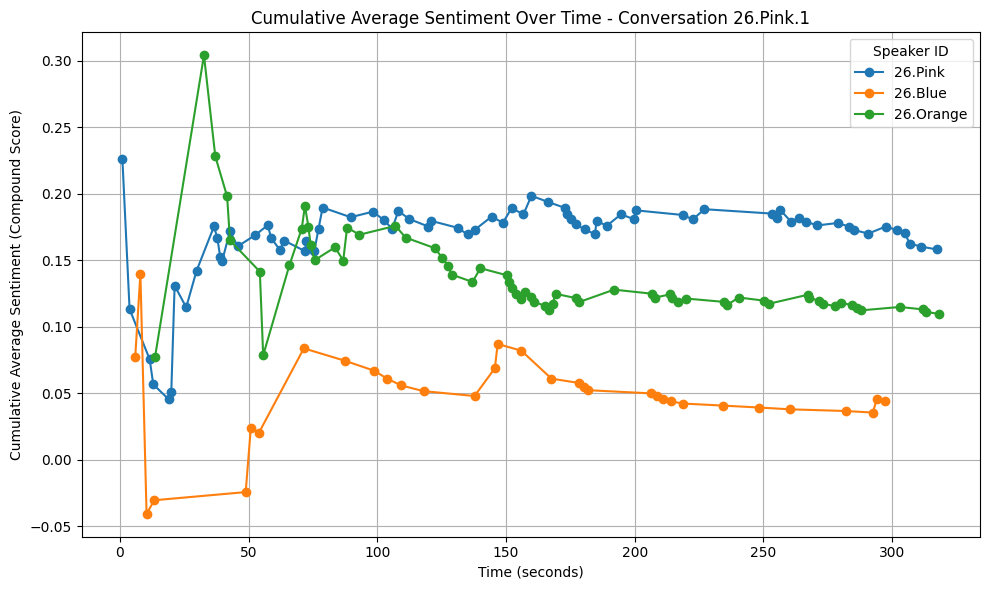

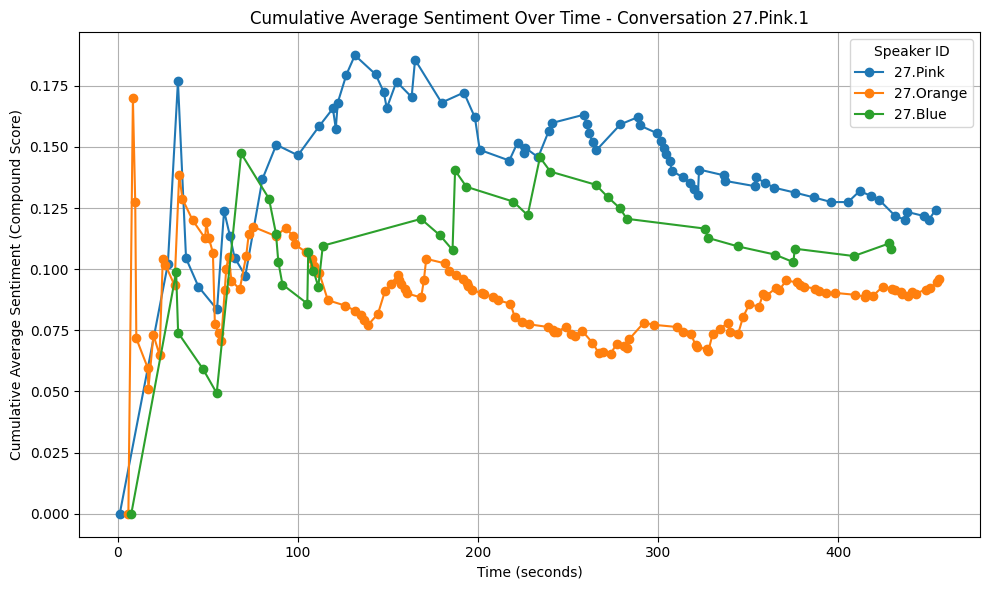

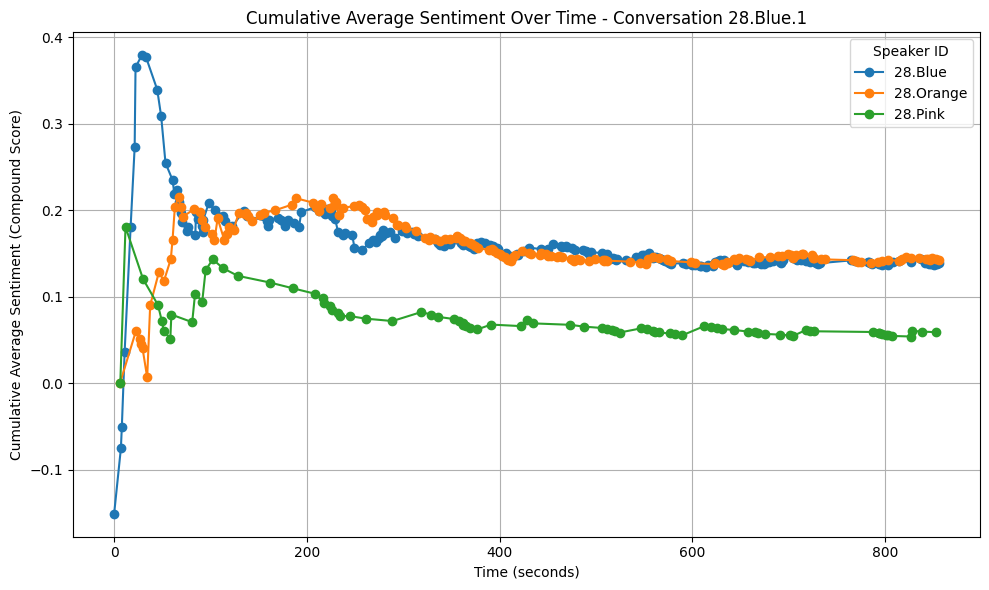

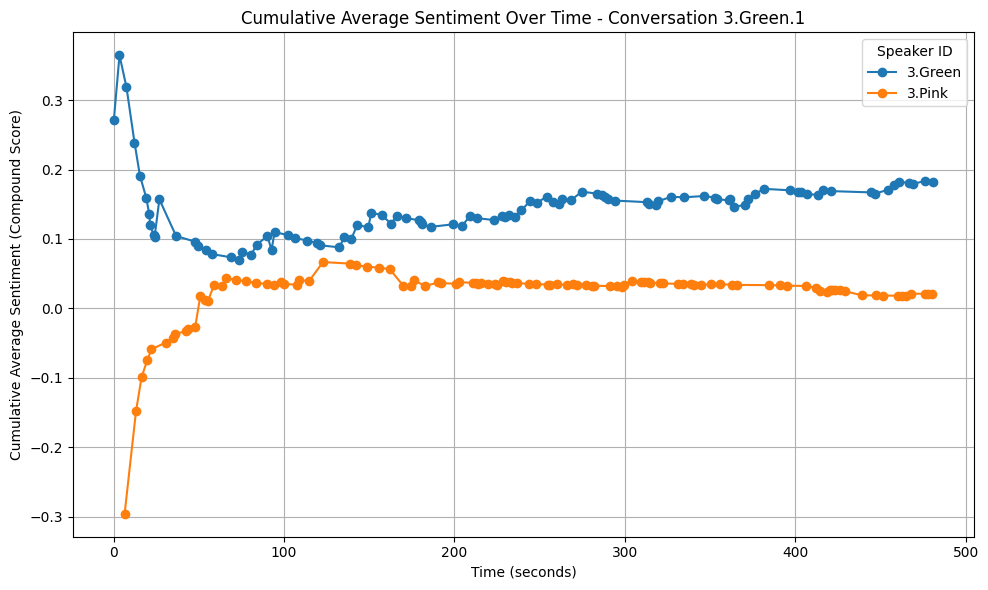

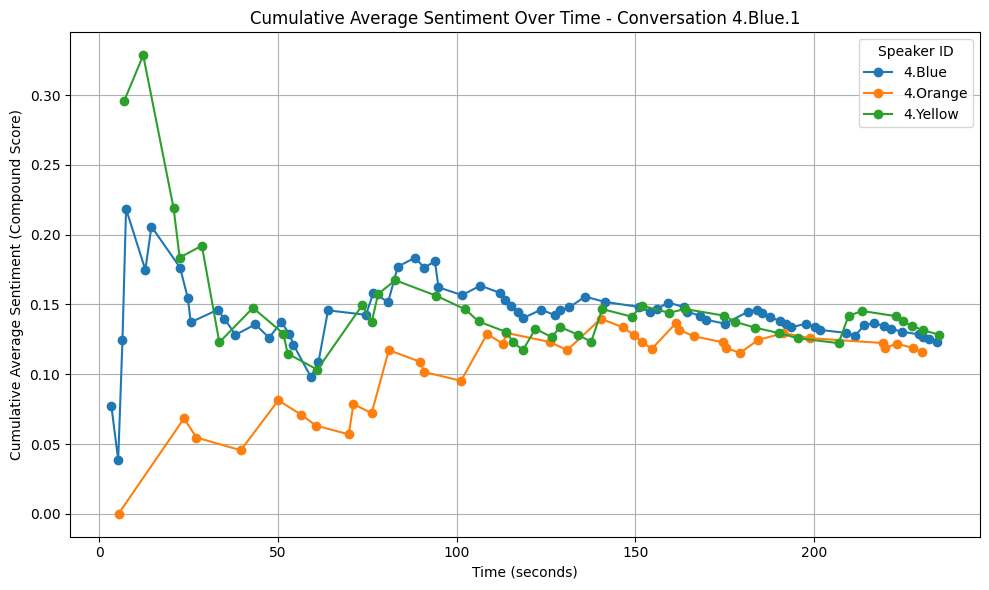

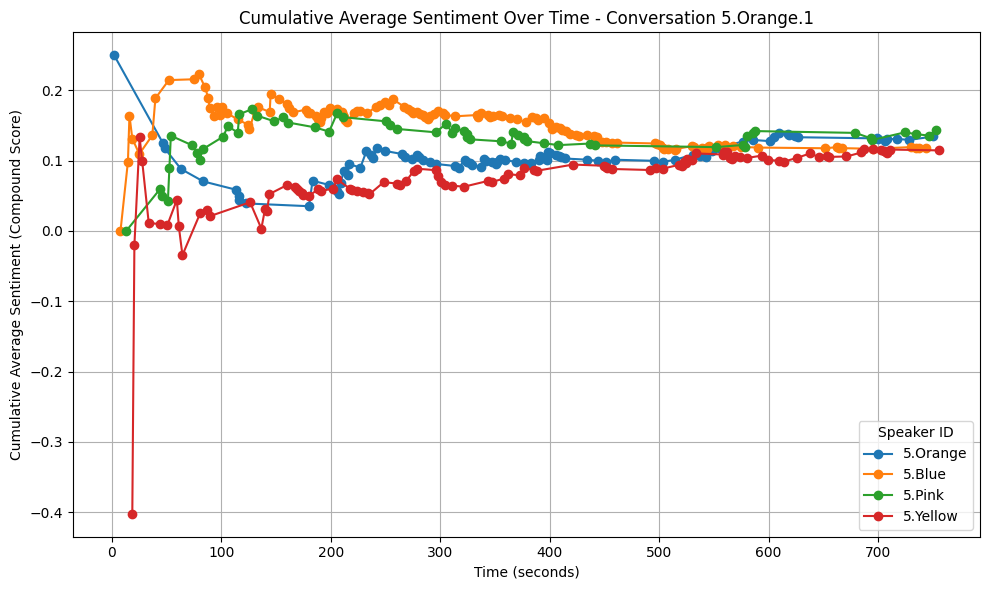

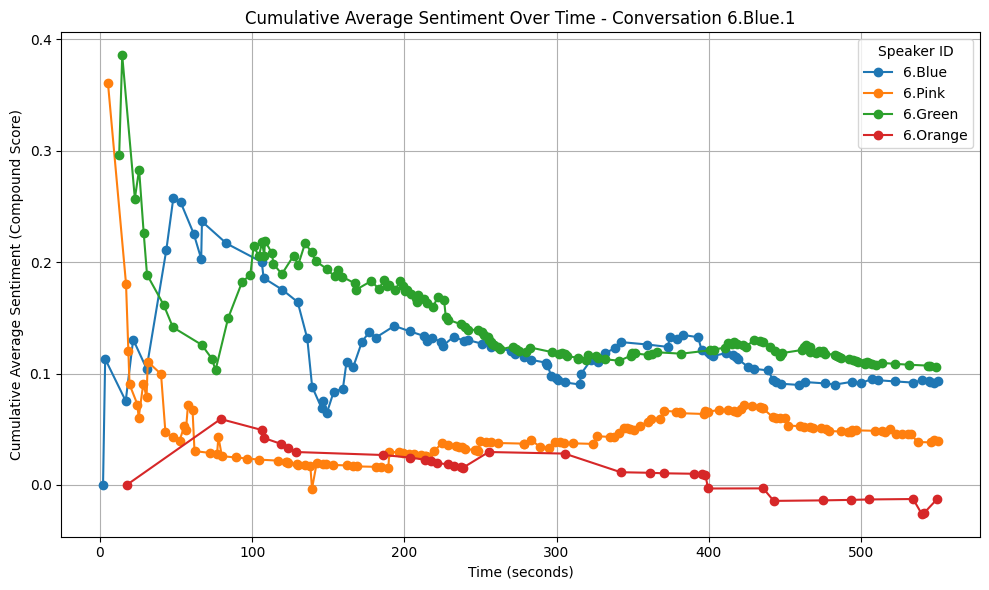

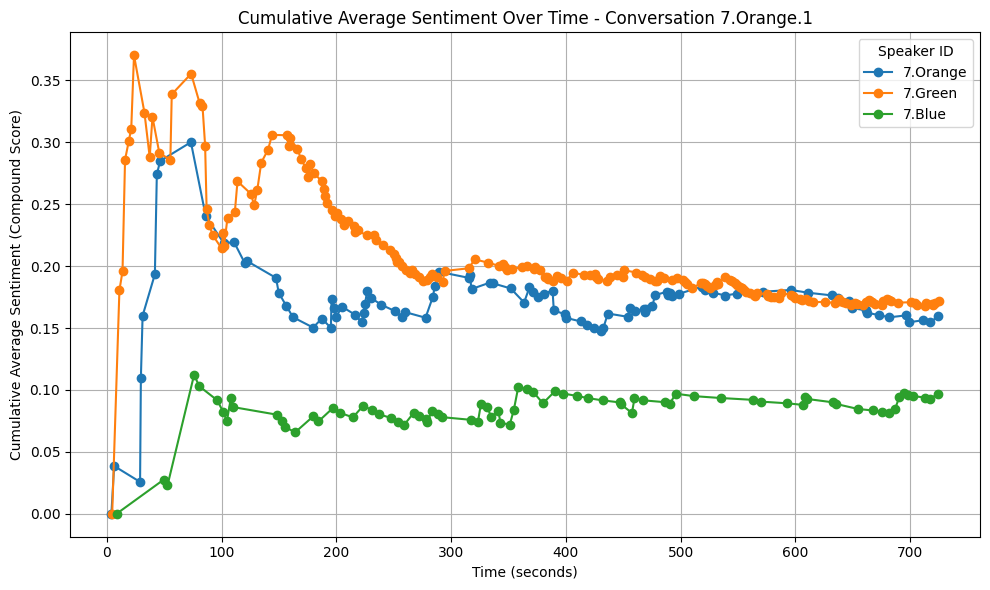

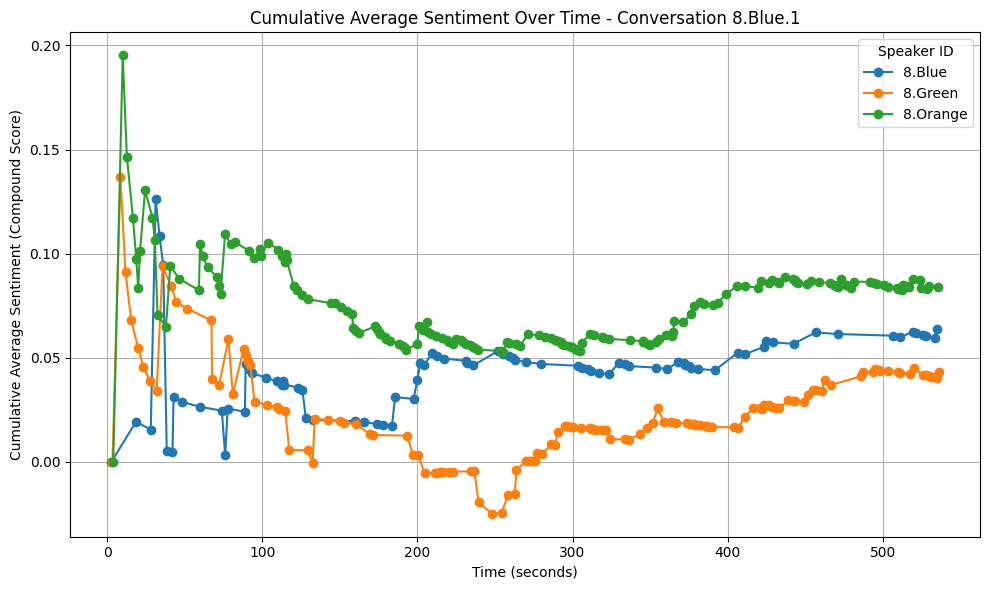

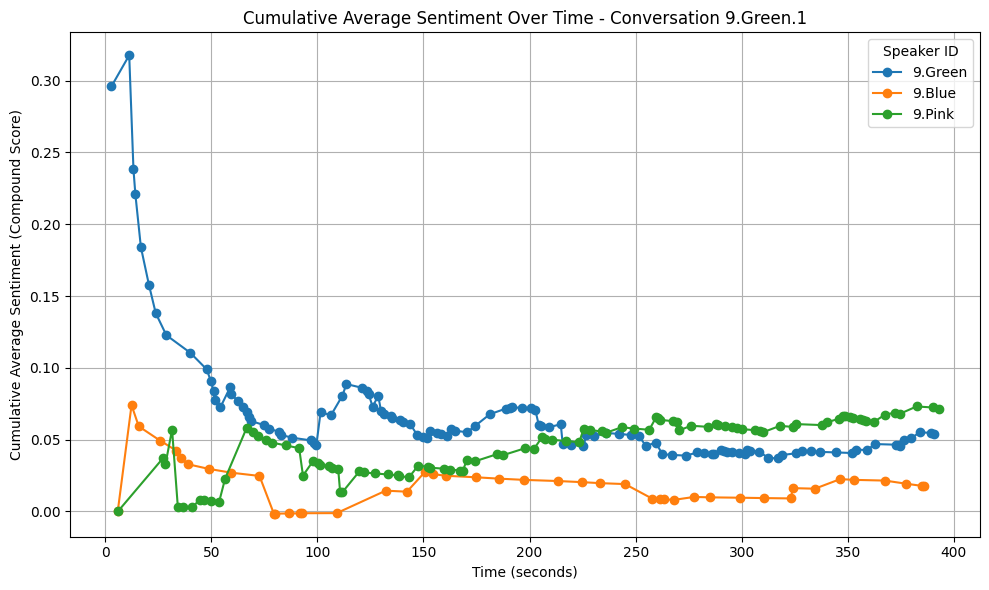

In [1]:
import matplotlib.pyplot as plt
import re
import numpy as np
from convokit import Corpus, download
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Ensure required resources are available
nltk.download('vader_lexicon')

corpus = Corpus(filename=download("gap-corpus"))
print("Download complete!")

# Initializes the VADER sentiment engine. It returns scores in a range of [-1, 1].
sia = SentimentIntensityAnalyzer()

def timestamp_to_seconds(timestamp_str):
    try:
        minutes, sec_dec = timestamp_str.split(":")
        return int(minutes) * 60 + float(sec_dec)
    except Exception as e:
        print(f"Error converting timestamp {timestamp_str}: {e}")
        return None

def collapse_consecutive_values(data_points):
    if not data_points:
        return data_points
    cleaned = []
    i = 0
    n = len(data_points)
    while i < n:
        cleaned.append(data_points[i])
        j = i + 1
        while j < n and np.isclose(data_points[j][1], data_points[i][1], atol=1e-8):
            j += 1
        i = j
    return cleaned

# For each conversation, compute cumulative average sentiment per speaker.
for conv_id, conversation in corpus.conversations.items():
    speaker_sentiment_data = {}      # key: speaker_id, value: list of (time, cumulative avg sentiment)
    speaker_running_sentiment = {}   # key: speaker_id, value: {'total_sentiment': float, 'utterance_count': int}
    
    # Sort utterances by timestamp.
    utterances = list(conversation.iter_utterances())
    utterances.sort(key=lambda utt: timestamp_to_seconds(utt.timestamp) if utt.timestamp else 0)
    
    for utt in utterances:
        if not utt.timestamp or not utt.text:
            continue
        time_sec = timestamp_to_seconds(utt.timestamp)
        if time_sec is None:
            continue
        speaker_id = utt.speaker.id
        text = utt.text.strip()
        if not text:
            continue
        # Compute sentiment (compound score) for the utterance.
        sentiment = sia.polarity_scores(text)['compound']
        if speaker_id not in speaker_running_sentiment:
            speaker_running_sentiment[speaker_id] = {'total_sentiment': 0.0, 'utterance_count': 0}
            speaker_sentiment_data[speaker_id] = []
        speaker_running_sentiment[speaker_id]['total_sentiment'] += sentiment
        speaker_running_sentiment[speaker_id]['utterance_count'] += 1
        avg_sentiment = speaker_running_sentiment[speaker_id]['total_sentiment'] / speaker_running_sentiment[speaker_id]['utterance_count']
        speaker_sentiment_data[speaker_id].append((time_sec, avg_sentiment))
    
    # Create the plot for the current conversation.
    plt.figure(figsize=(10, 6))
    plt.title(f"Cumulative Average Sentiment Over Time - Conversation {conv_id}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Cumulative Average Sentiment (Compound Score)")
    
    for speaker_id, data_points in speaker_sentiment_data.items():
        cleaned_points = collapse_consecutive_values(data_points)
        cleaned_points.sort(key=lambda x: x[0])
        times = [pt[0] for pt in cleaned_points]
        avg_sentiments = [pt[1] for pt in cleaned_points]
        plt.plot(times, avg_sentiments, marker='o', label=speaker_id)
    
    plt.legend(title="Speaker ID")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sofiansyed/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dataset already exists at /Users/sofiansyed/.convokit/saved-corpora/gap-corpus
Download complete!


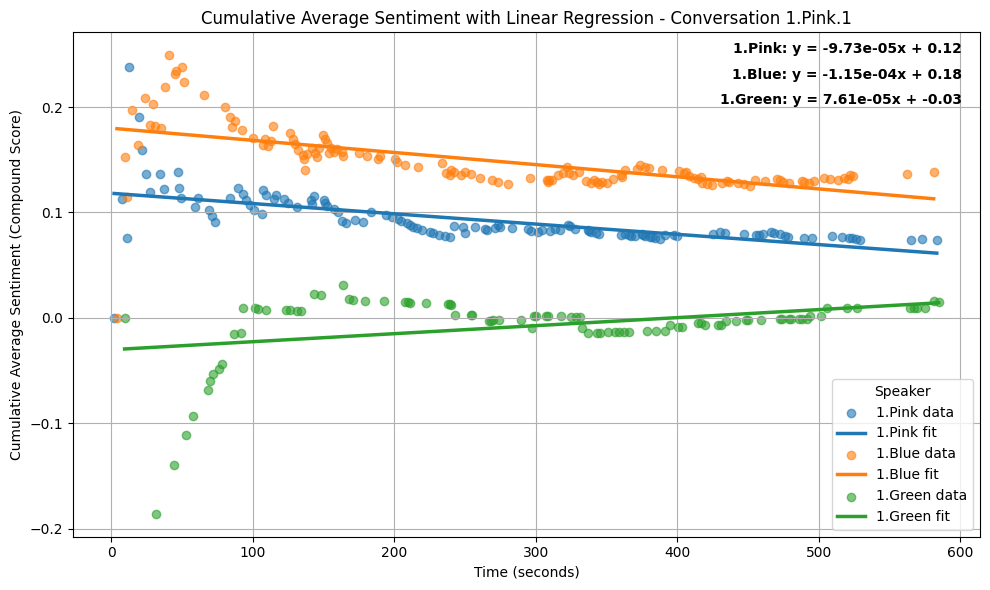

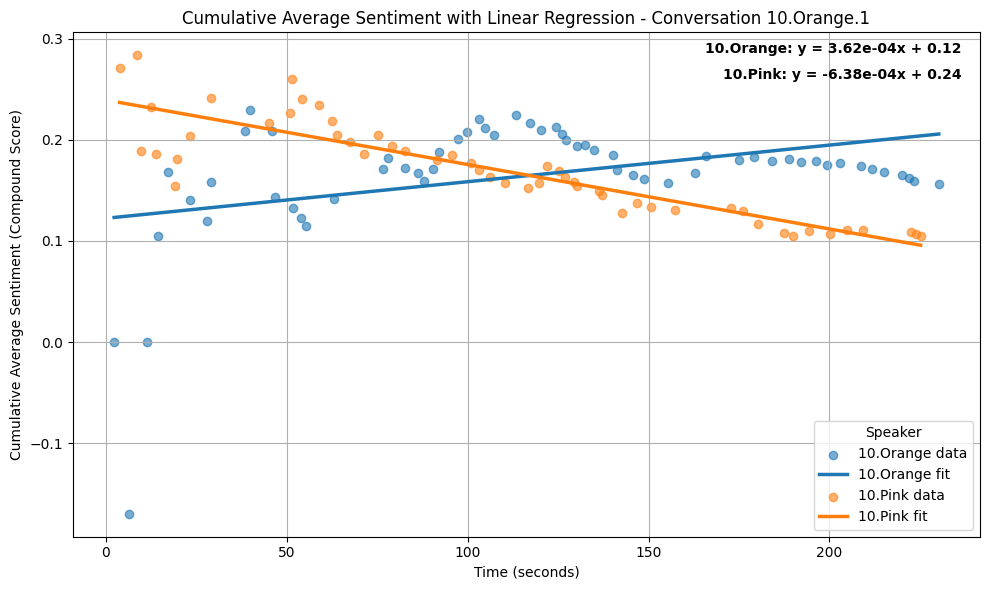

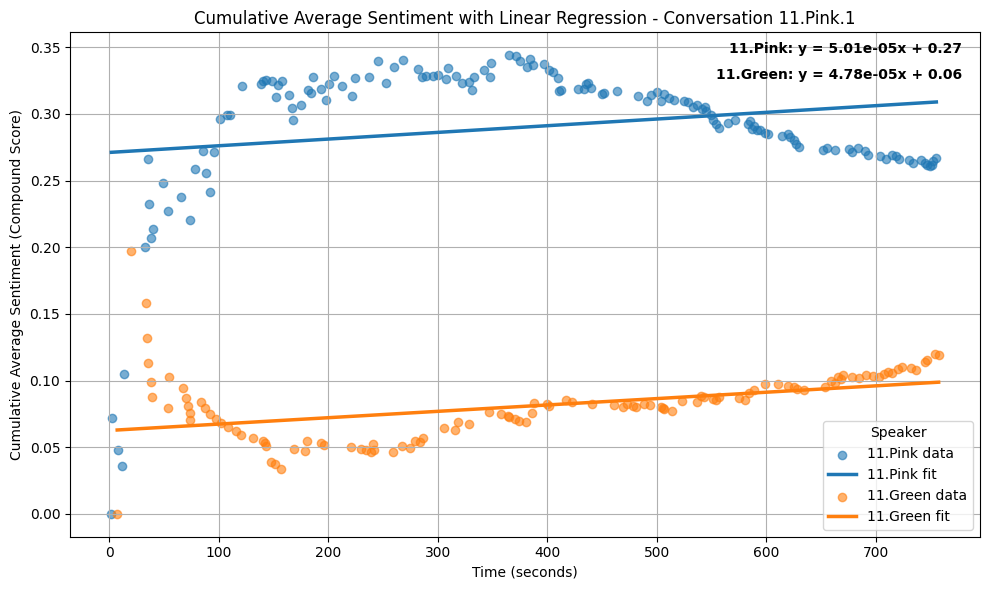

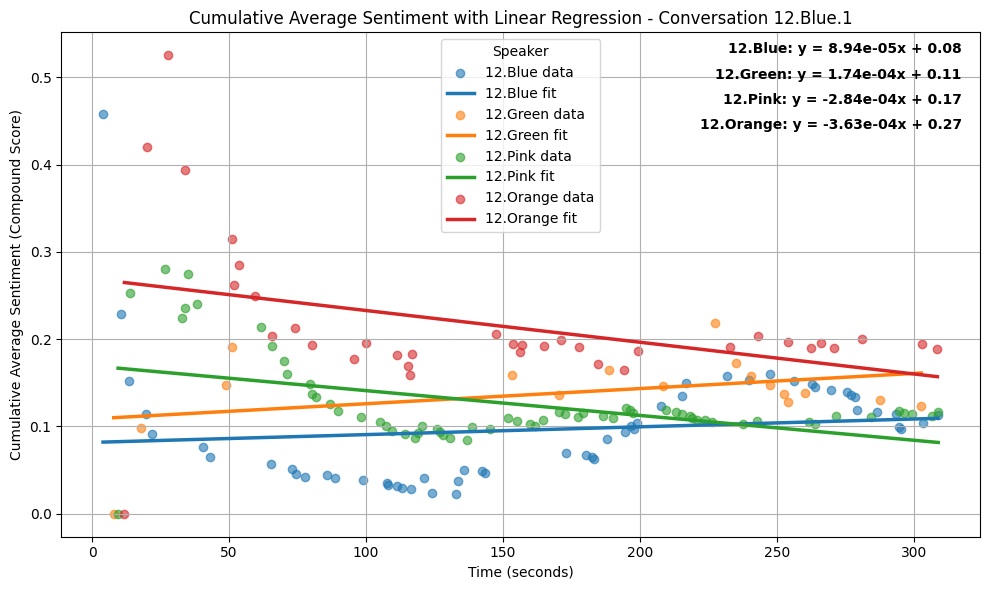

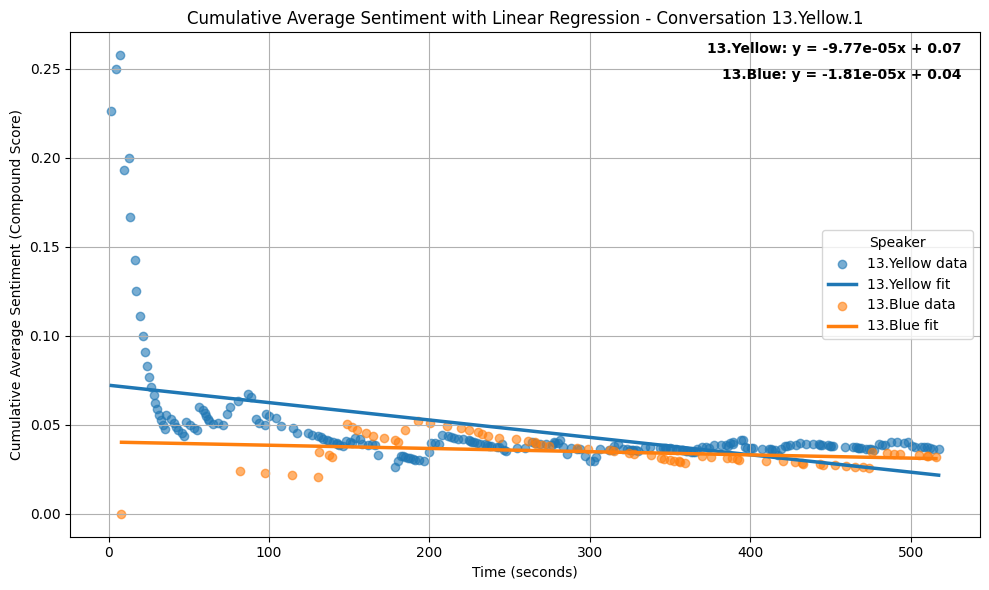

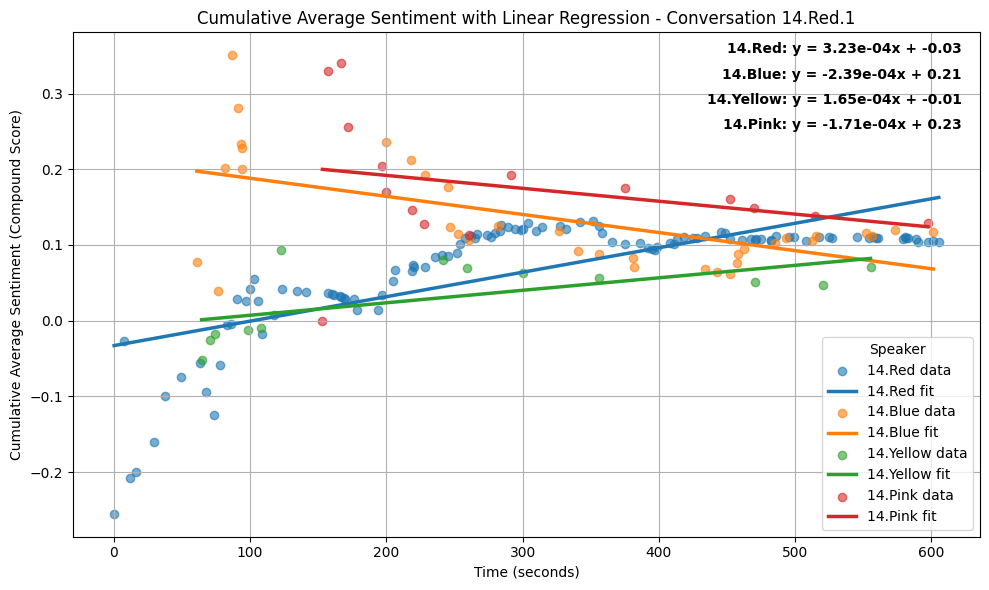

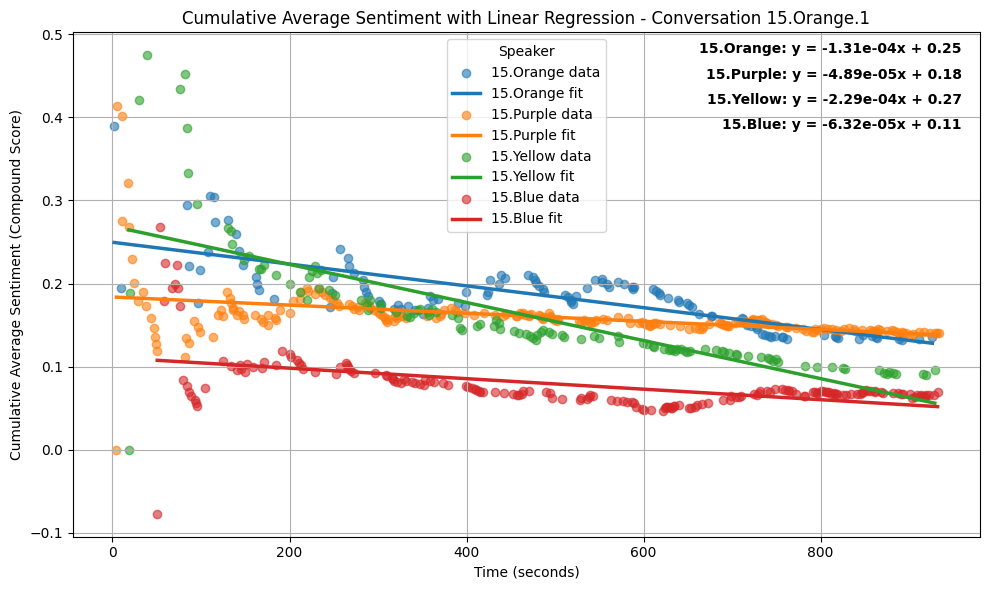

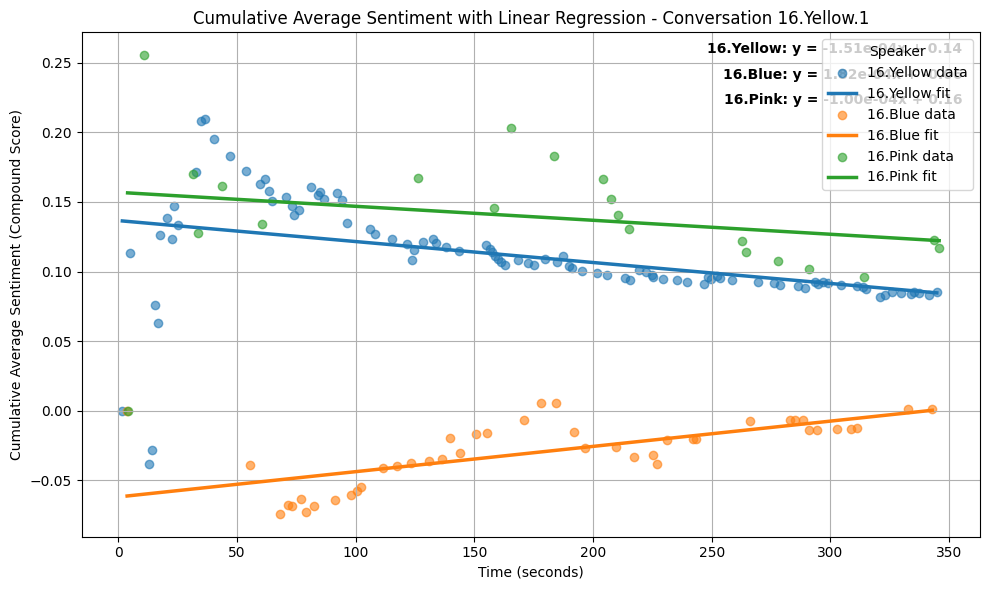

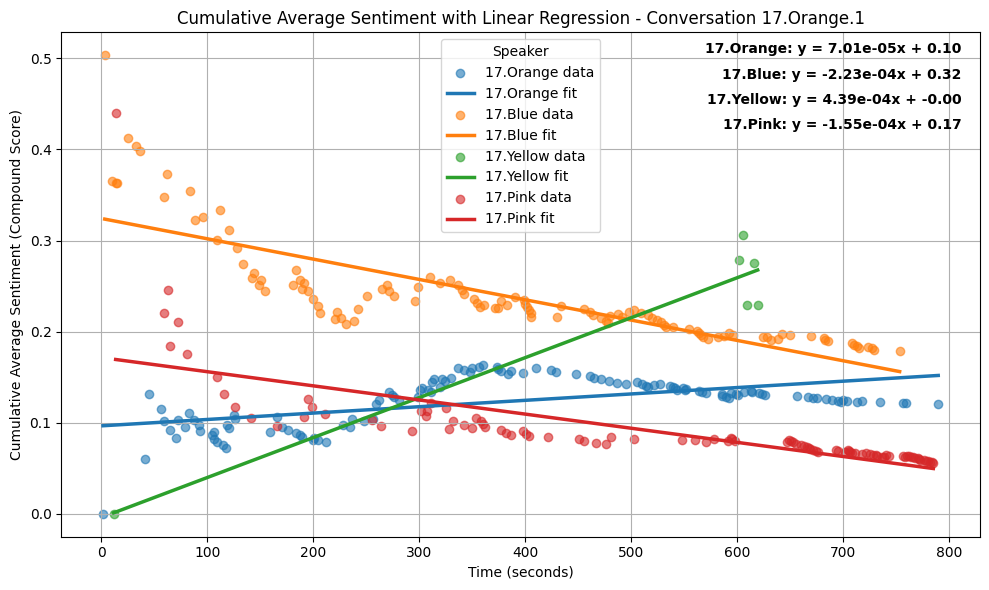

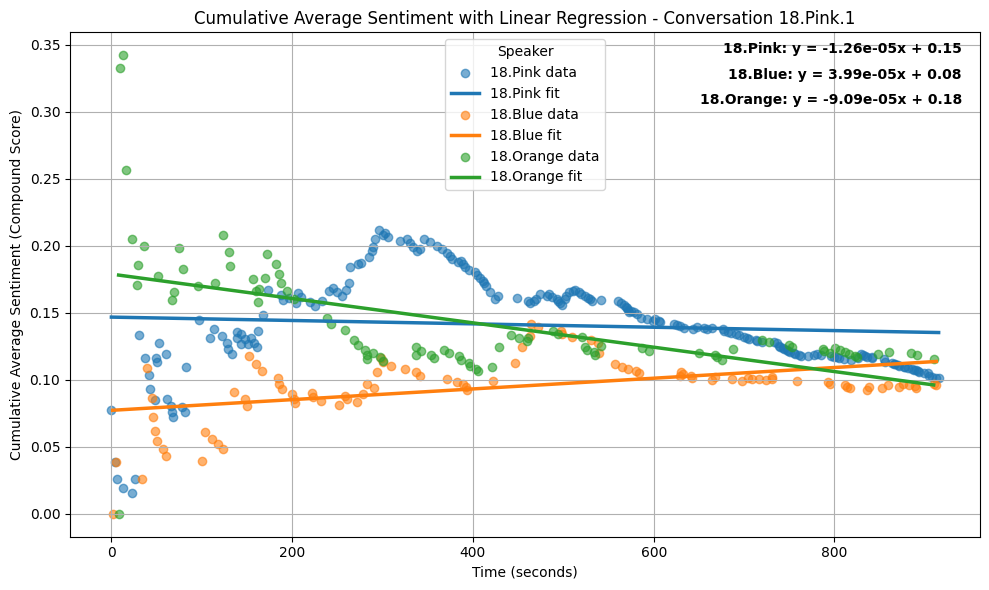

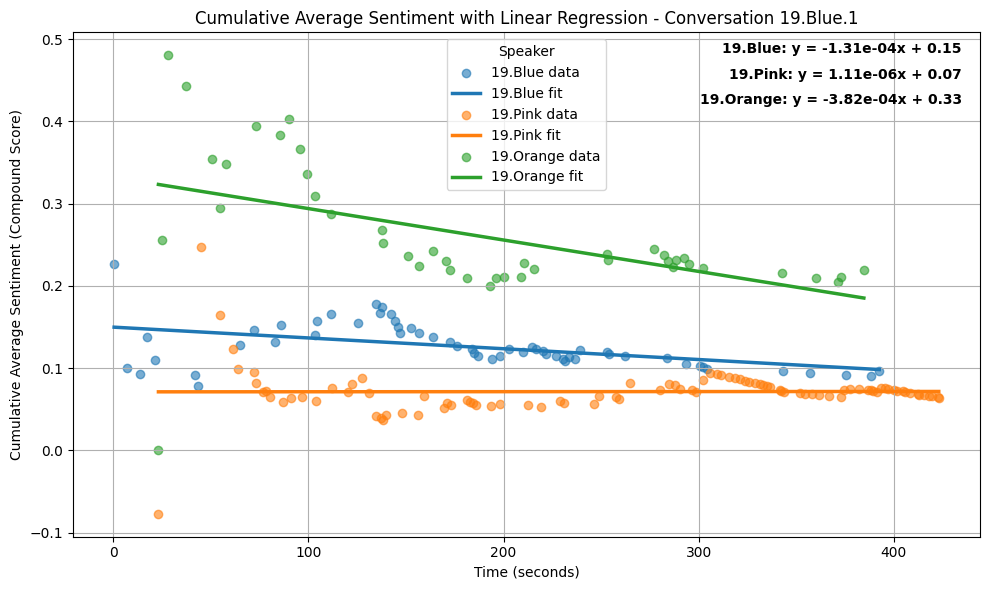

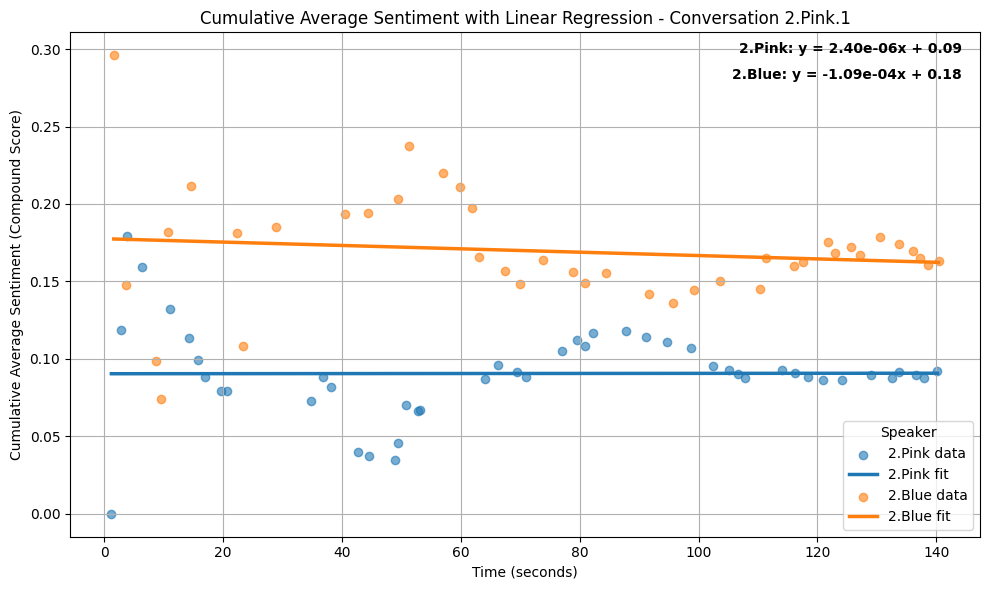

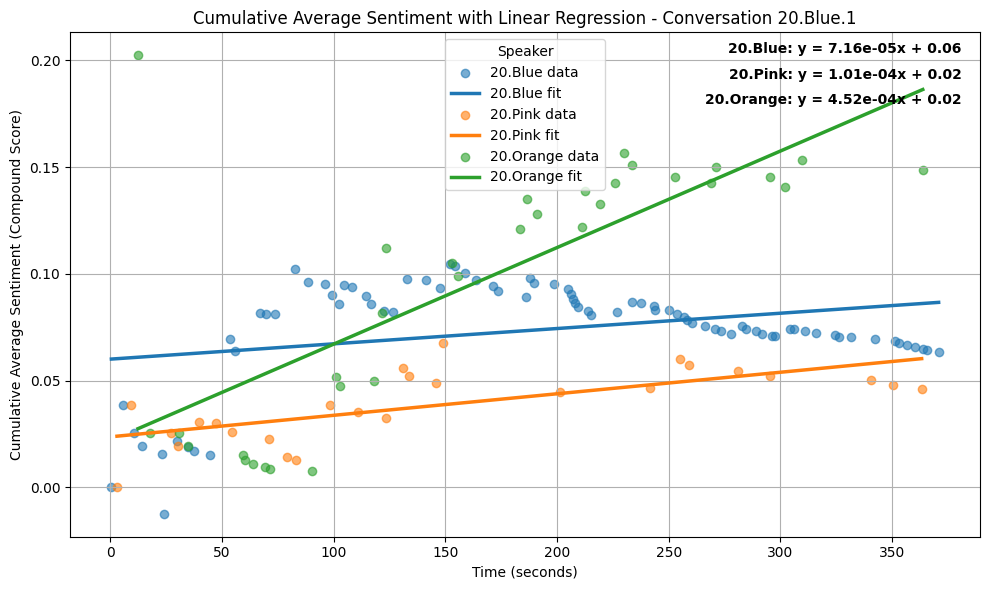

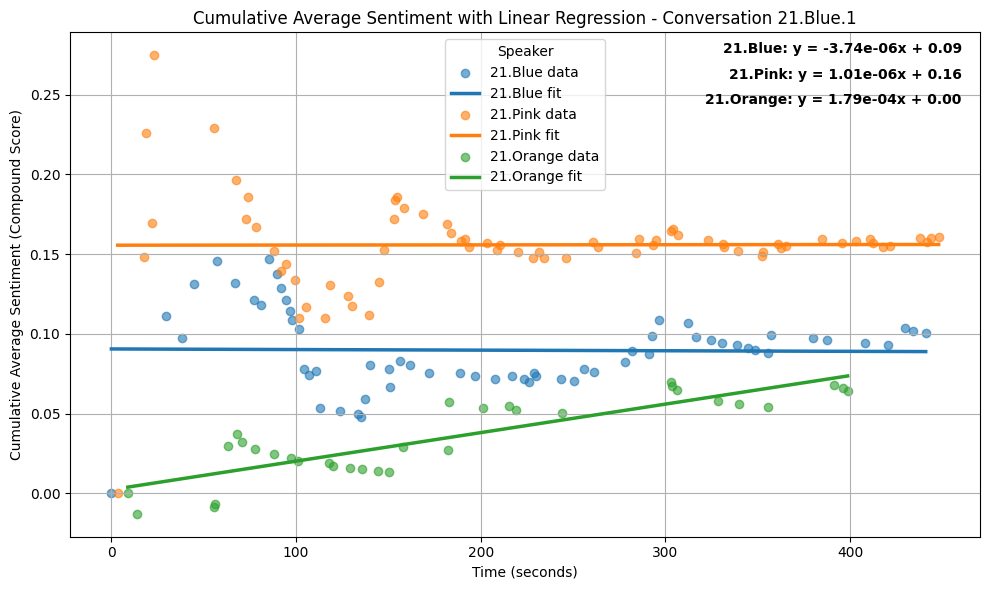

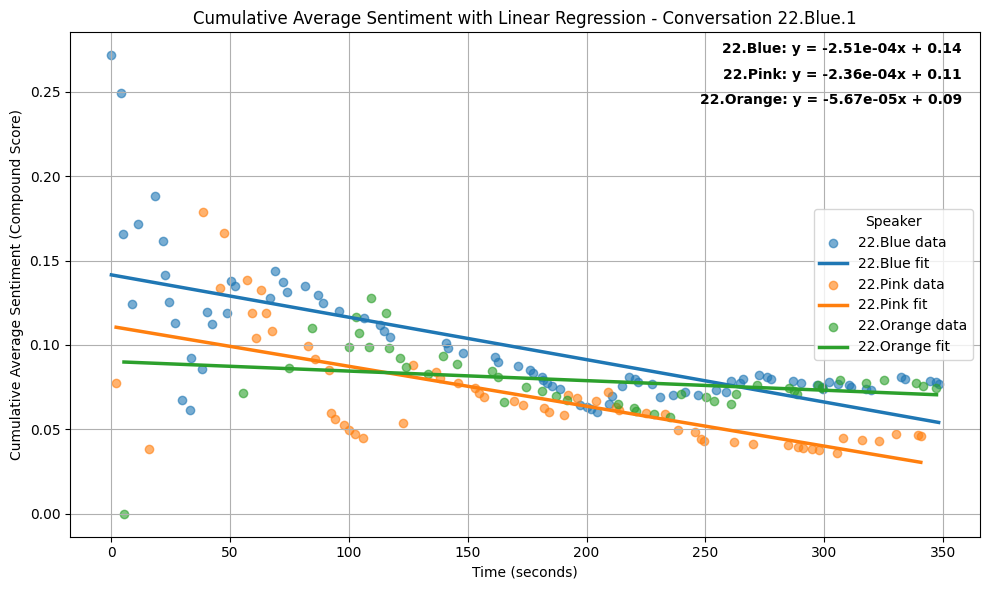

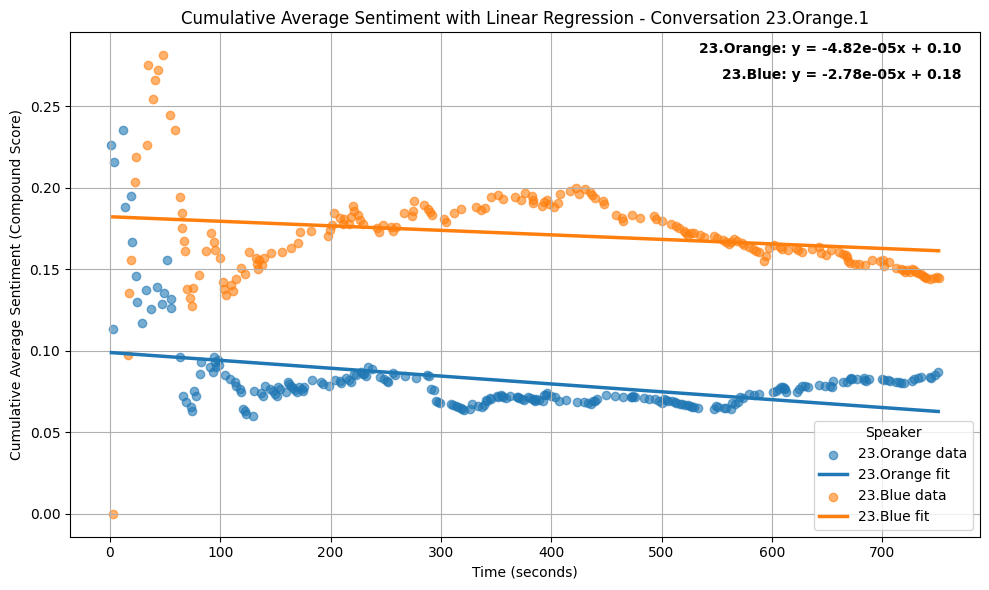

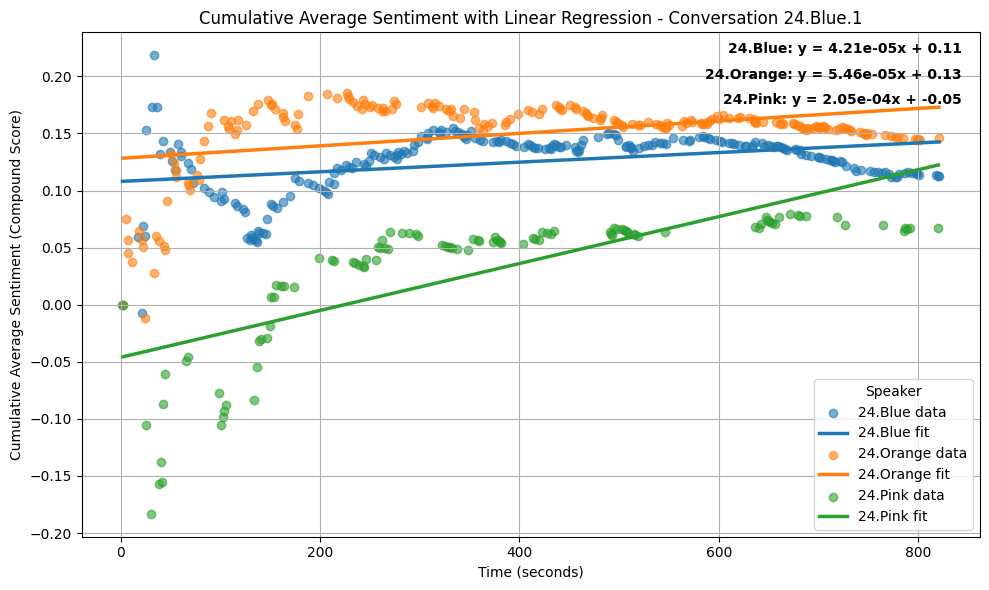

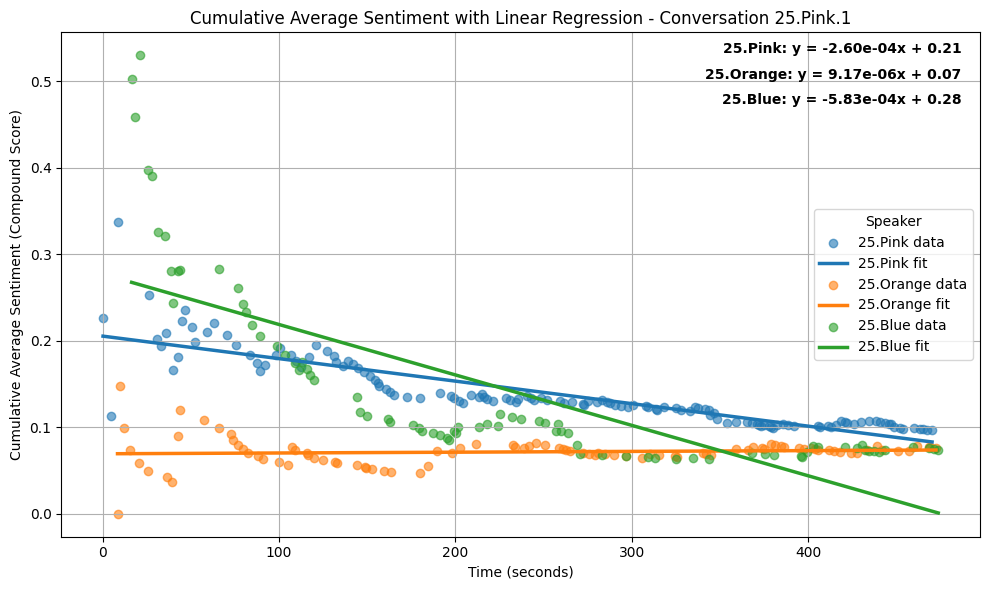

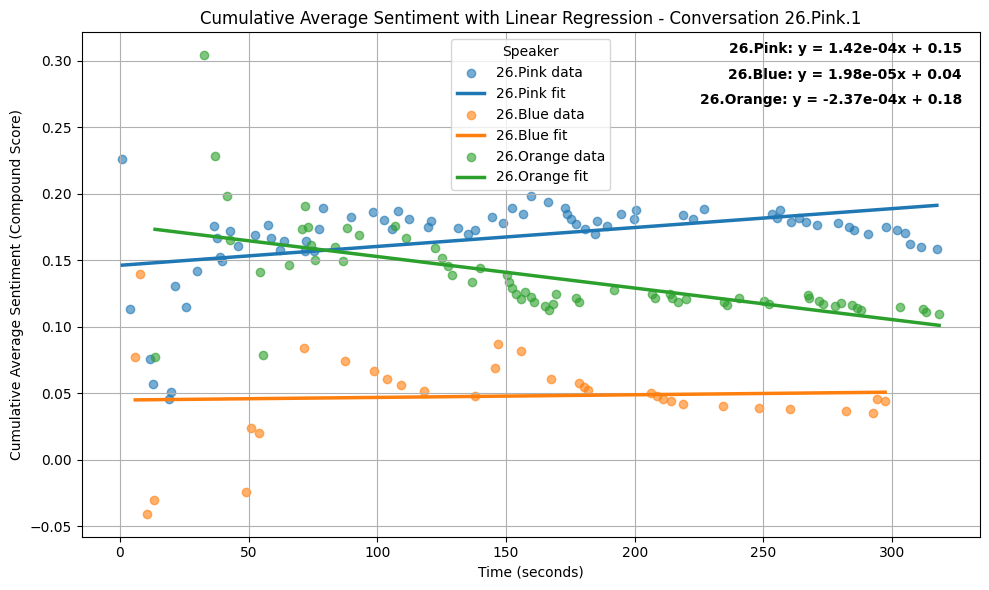

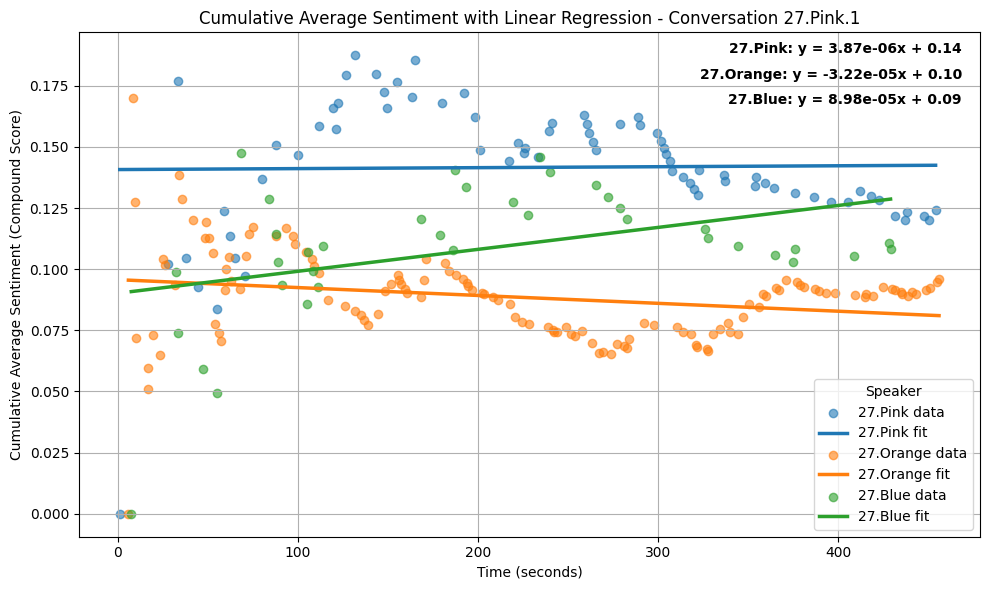

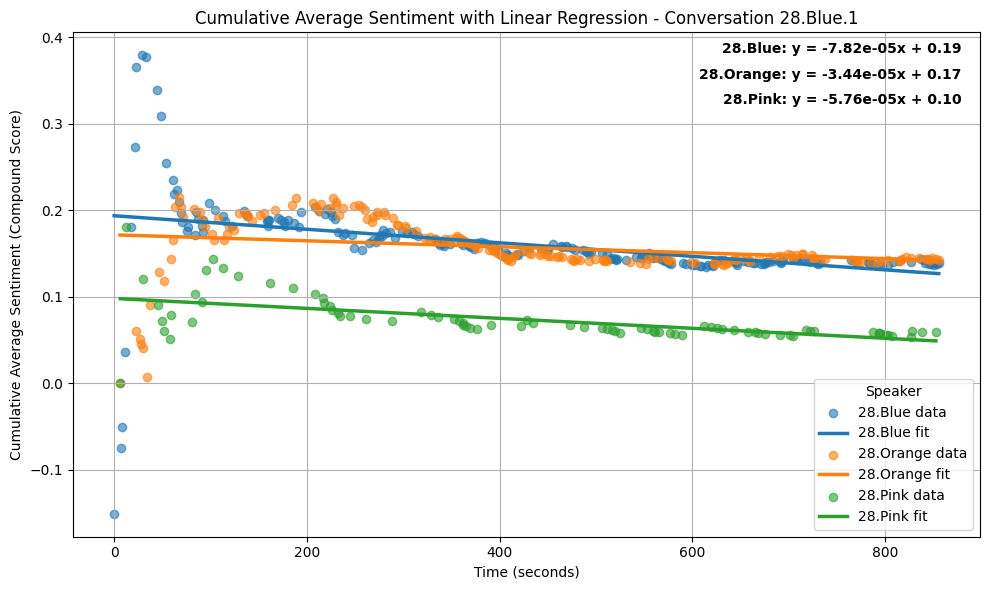

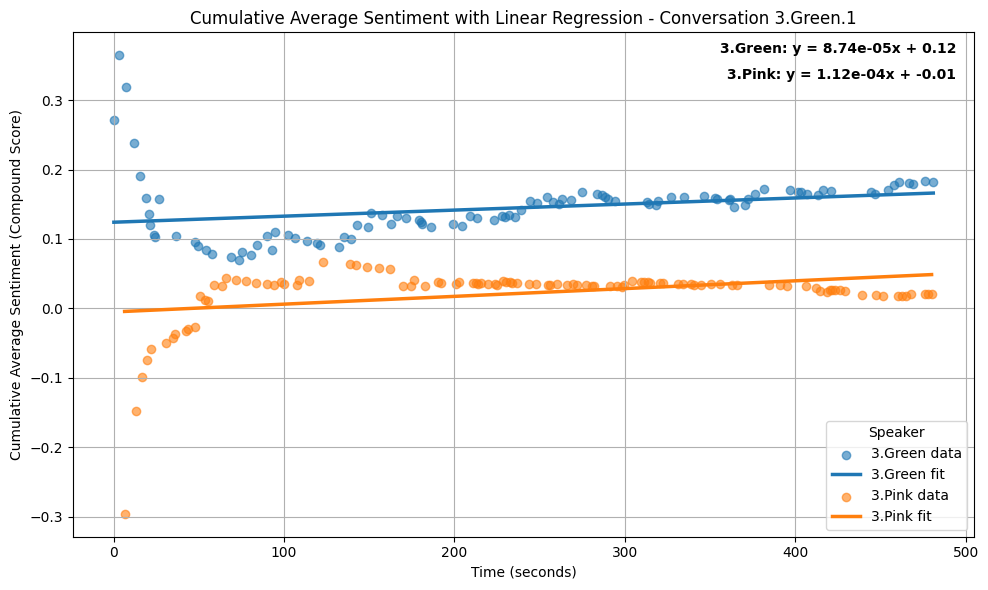

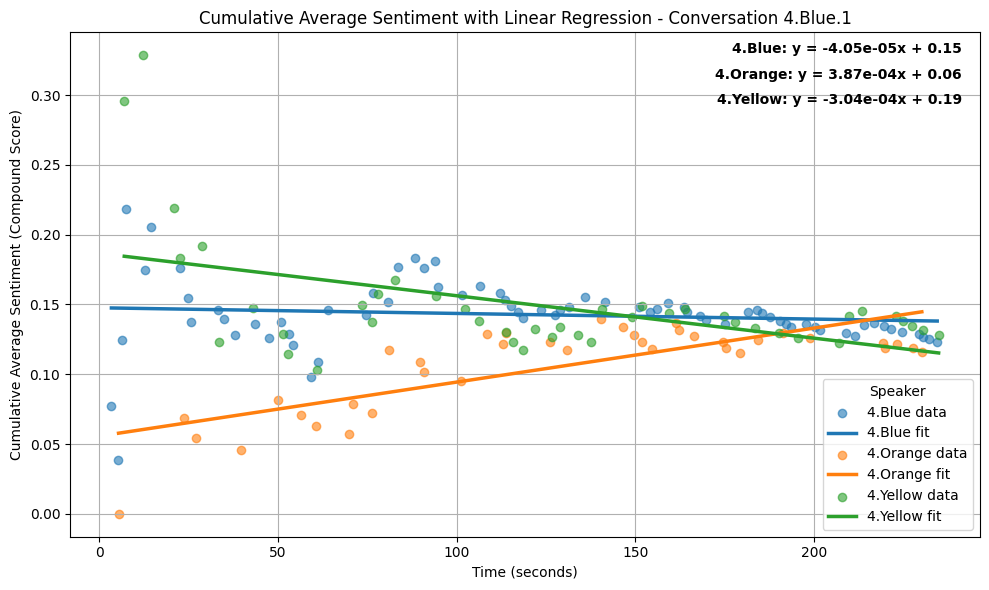

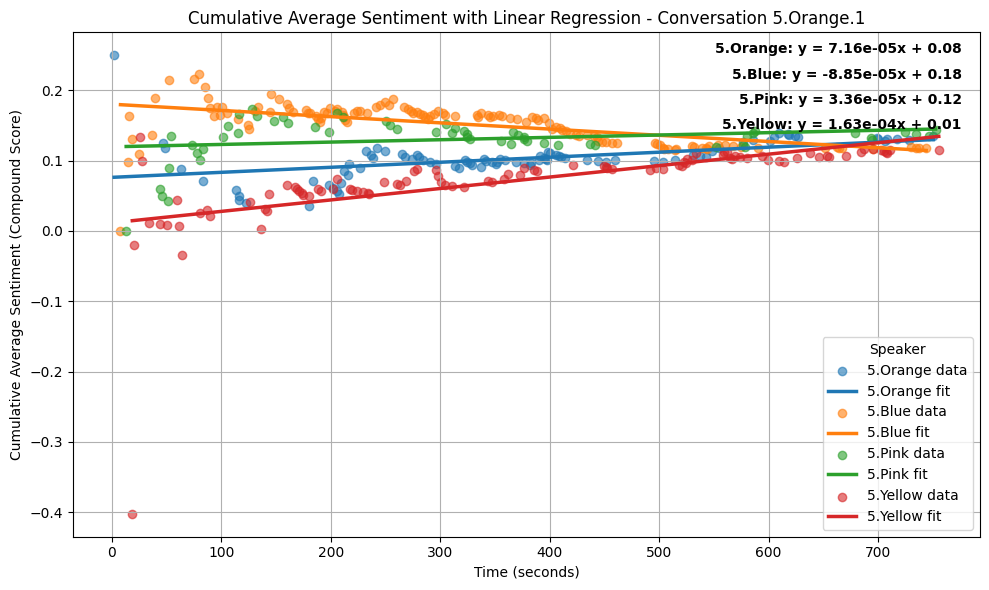

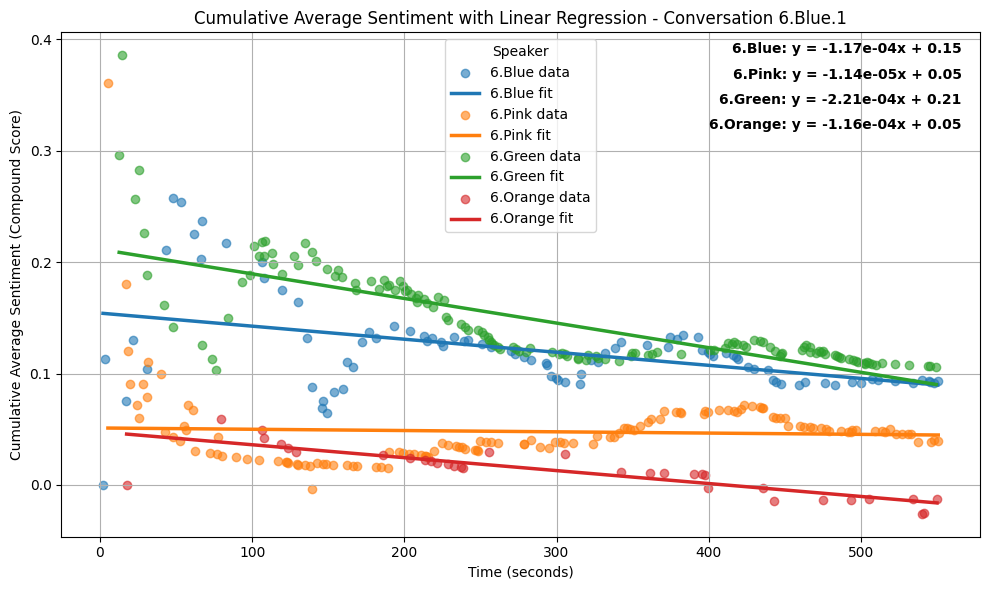

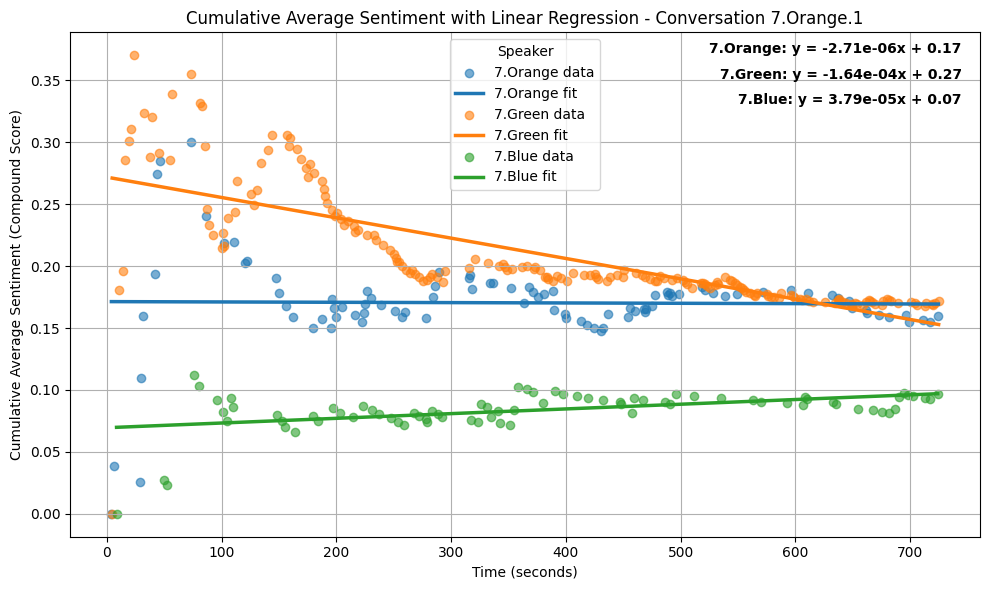

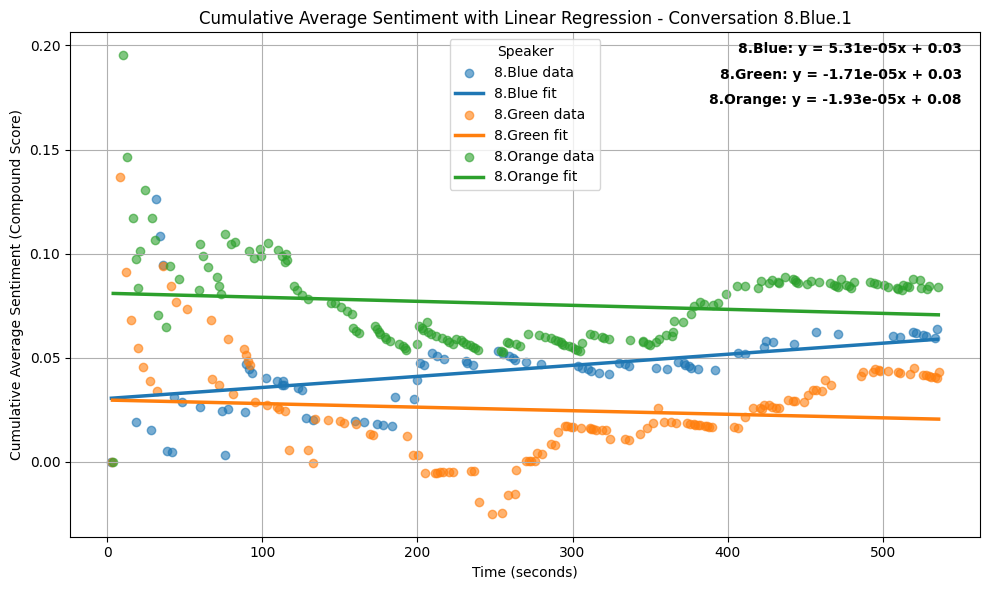

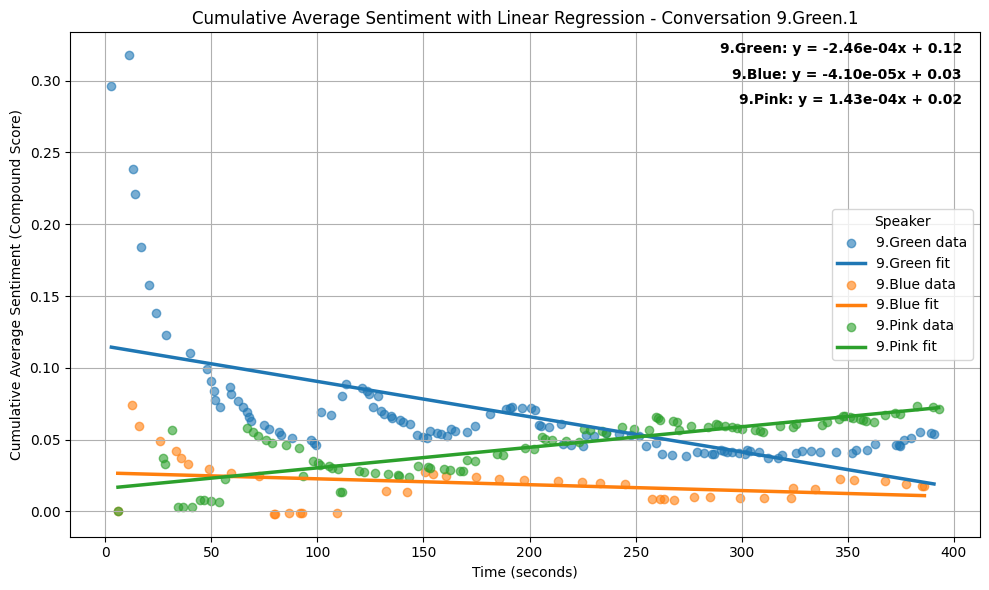

In [2]:
import matplotlib.pyplot as plt
import re
import numpy as np
from convokit import Corpus, download
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Same as Block 1 but adds a regression line to track the overall trend.

nltk.download('vader_lexicon')
corpus = Corpus(filename=download("gap-corpus"))
print("Download complete!")

sia = SentimentIntensityAnalyzer()

# For each conversation, compute cumulative average sentiment and fit a linear regression.
for conv_id, conversation in corpus.conversations.items():
    speaker_sentiment_data = {}
    speaker_running_sentiment = {}
    
    utterances = list(conversation.iter_utterances())
    utterances.sort(key=lambda utt: timestamp_to_seconds(utt.timestamp) if utt.timestamp else 0)
    
    for utt in utterances:
        if not utt.timestamp or not utt.text:
            continue
        time_sec = timestamp_to_seconds(utt.timestamp)
        if time_sec is None:
            continue
        speaker_id = utt.speaker.id
        text = utt.text.strip()
        if not text:
            continue
        sentiment = sia.polarity_scores(text)['compound']
        if speaker_id not in speaker_running_sentiment:
            speaker_running_sentiment[speaker_id] = {'total_sentiment': 0.0, 'utterance_count': 0}
            speaker_sentiment_data[speaker_id] = []
        speaker_running_sentiment[speaker_id]['total_sentiment'] += sentiment
        speaker_running_sentiment[speaker_id]['utterance_count'] += 1
        avg_sentiment = speaker_running_sentiment[speaker_id]['total_sentiment'] / speaker_running_sentiment[speaker_id]['utterance_count']
        speaker_sentiment_data[speaker_id].append((time_sec, avg_sentiment))
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Cumulative Average Sentiment with Linear Regression - Conversation {conv_id}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Cumulative Average Sentiment (Compound Score)")
    
    equation_texts = []
    
    for speaker_id, data_points in speaker_sentiment_data.items():
        data_points.sort(key=lambda x: x[0])
        cleaned_points = collapse_consecutive_values(data_points)
        times = np.array([pt[0] for pt in cleaned_points])
        sentiments = np.array([pt[1] for pt in cleaned_points])
        if len(times) < 2:
            continue  # Not enough data for regression.
        
        # Fit a linear regression.
        slope, intercept = np.polyfit(times, sentiments, 1)
        reg_x = np.linspace(times.min(), times.max(), 100)
        reg_y = slope * reg_x + intercept
        
        plt.scatter(times, sentiments, label=f"{speaker_id} data", alpha=0.6)
        plt.plot(reg_x, reg_y, linewidth=2.5, label=f"{speaker_id} fit")
        
        eq_text = f"{speaker_id}: y = {slope:.2e}x + {intercept:.2f}"
        equation_texts.append(eq_text)
    
    for i, eq in enumerate(equation_texts):
        plt.text(0.98, 0.98 - i * 0.05, eq,
                 transform=plt.gca().transAxes,
                 ha='right', va='top', fontweight='bold', fontsize=10)
    
    plt.legend(title="Speaker")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sofiansyed/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Dataset already exists at /Users/sofiansyed/.convokit/saved-corpora/gap-corpus
Download complete!


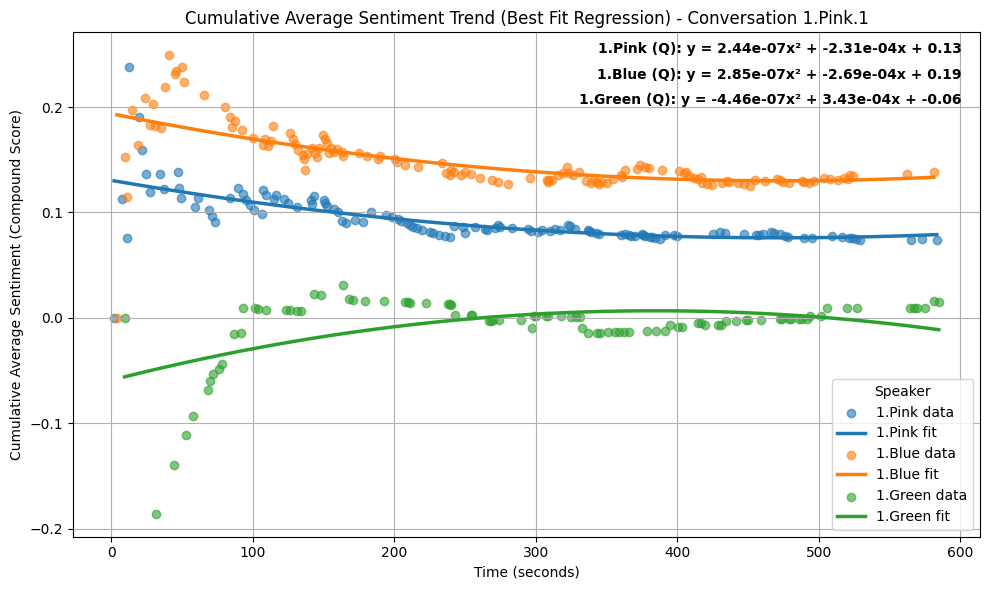

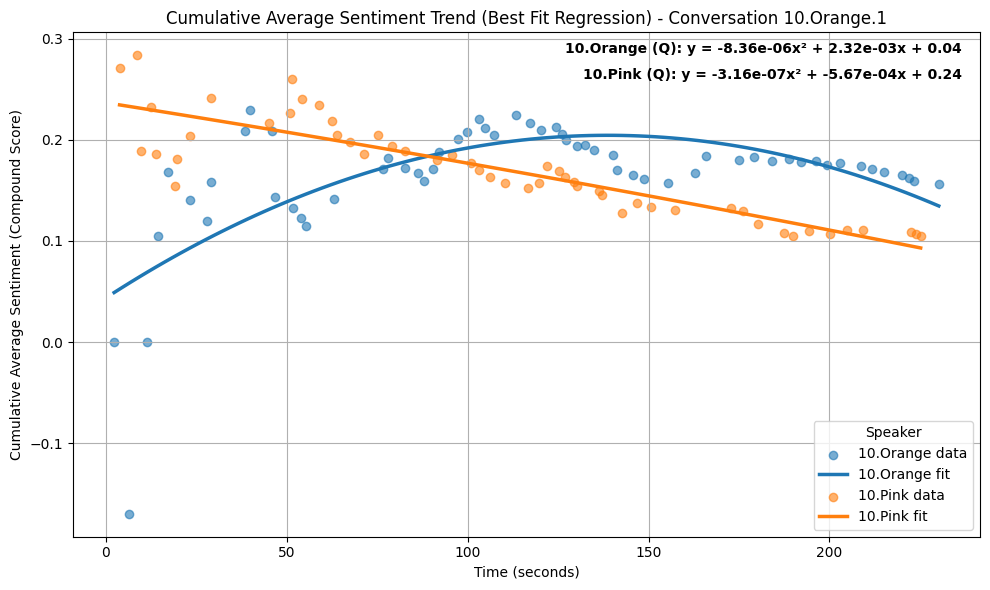

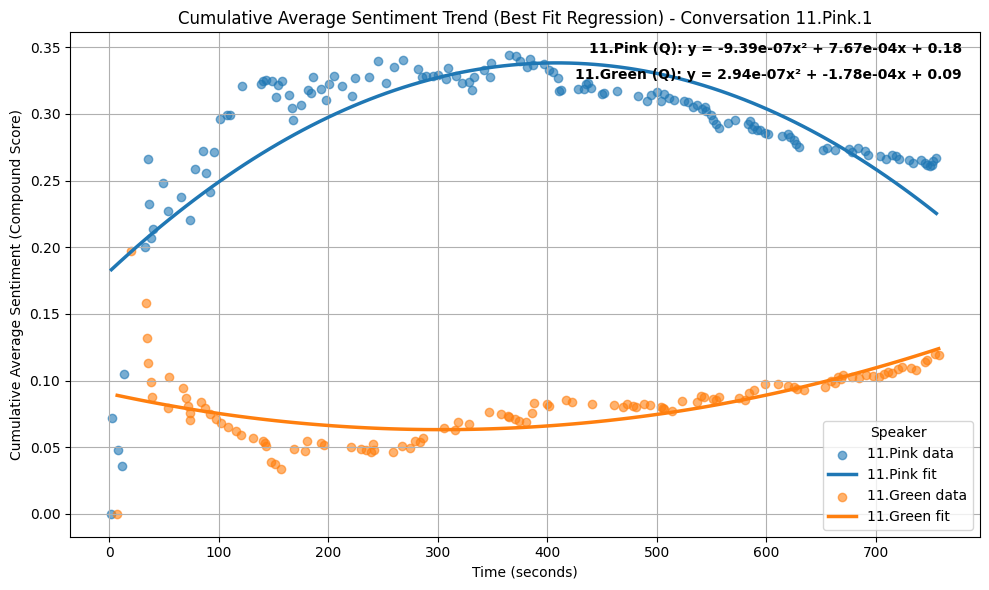

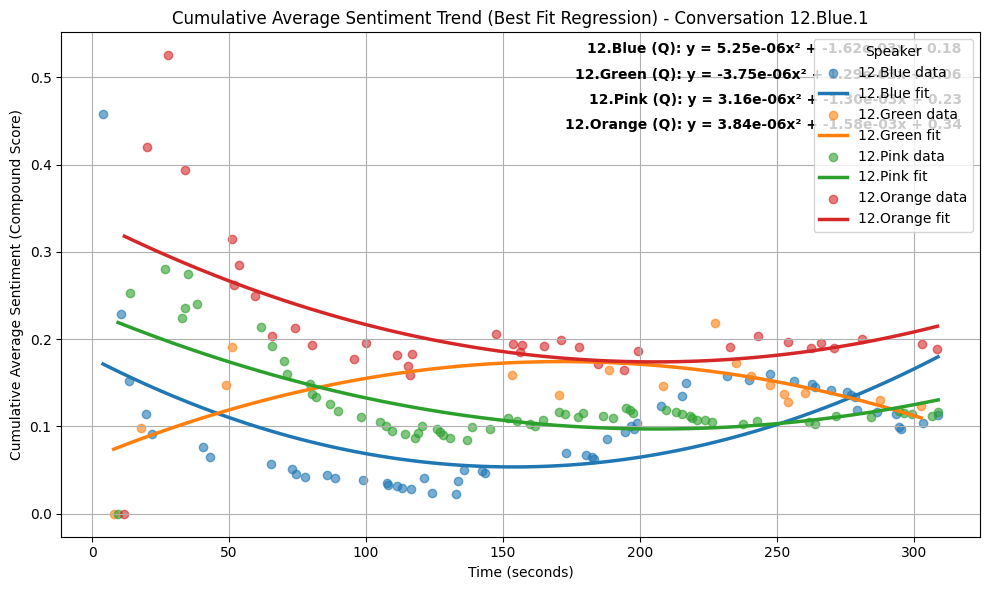

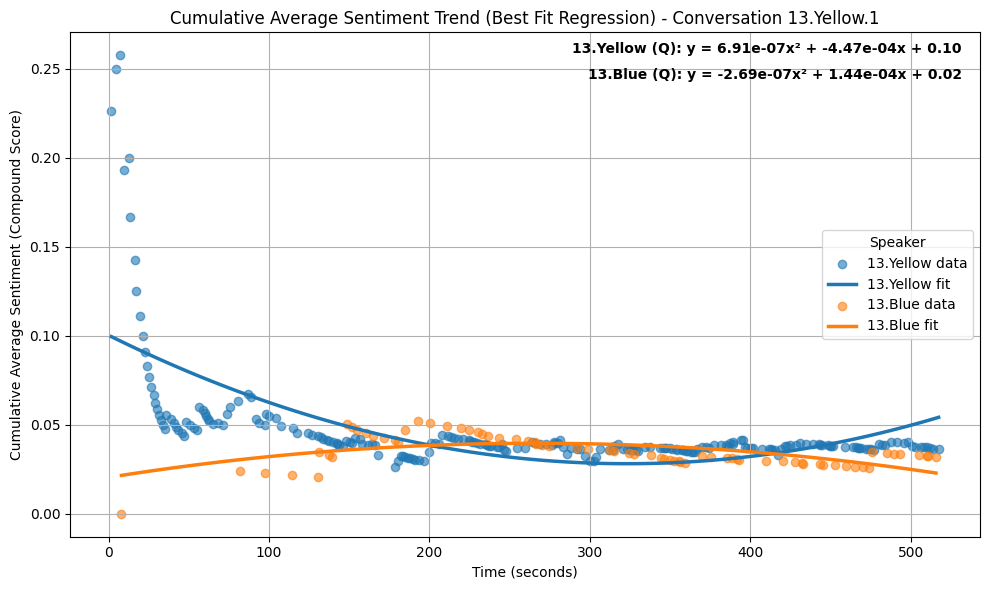

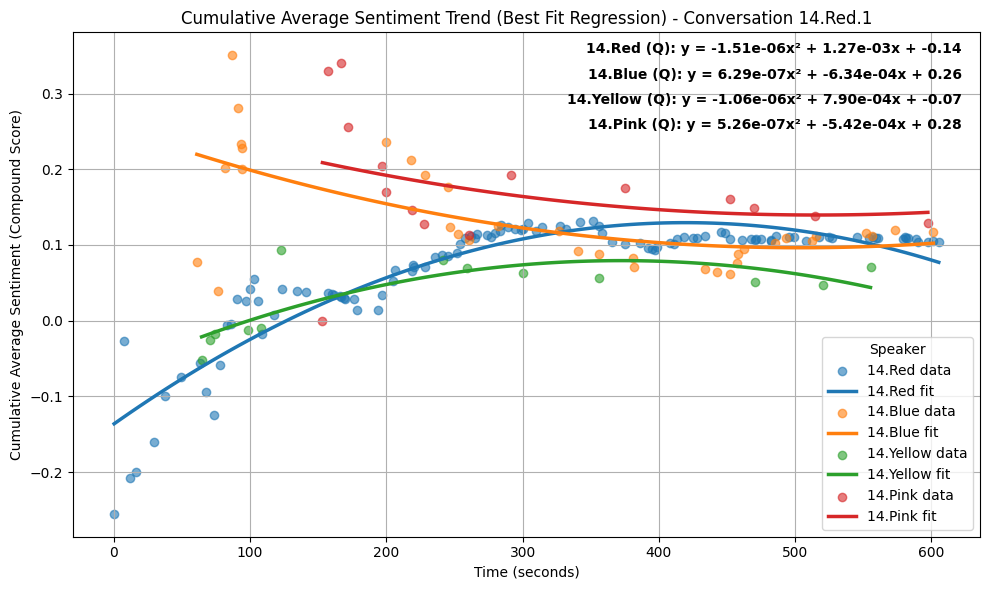

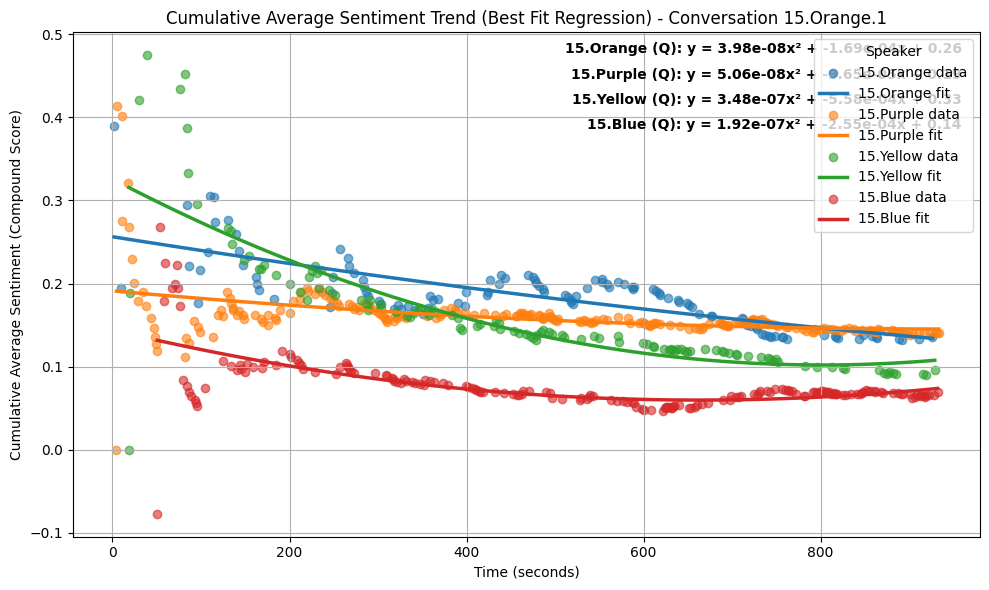

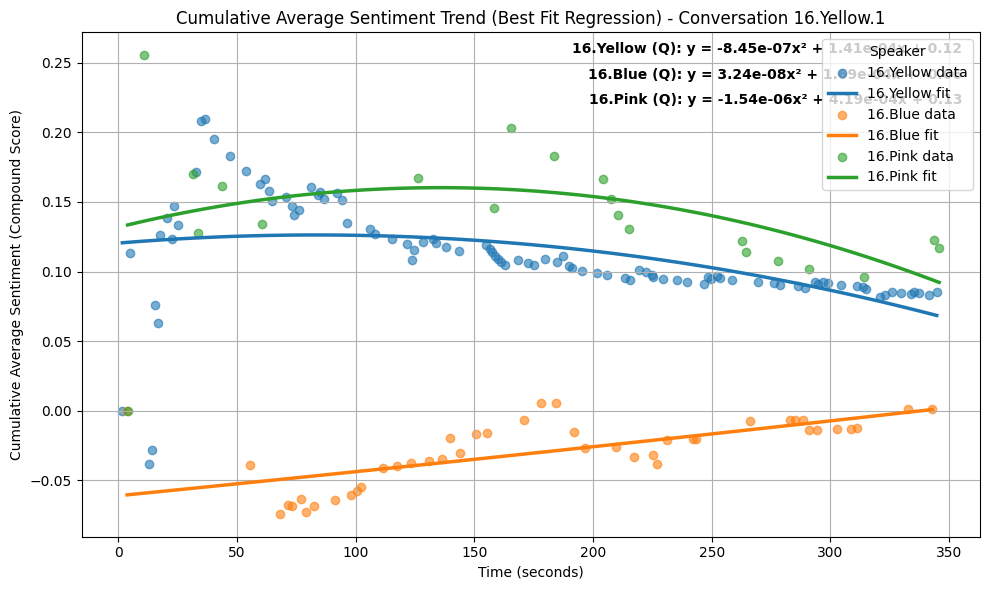

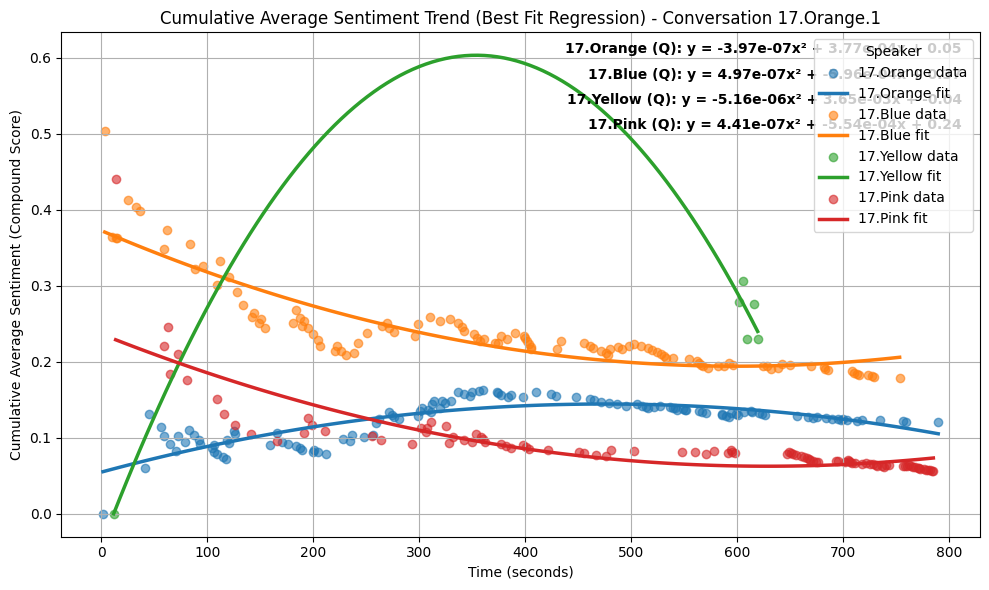

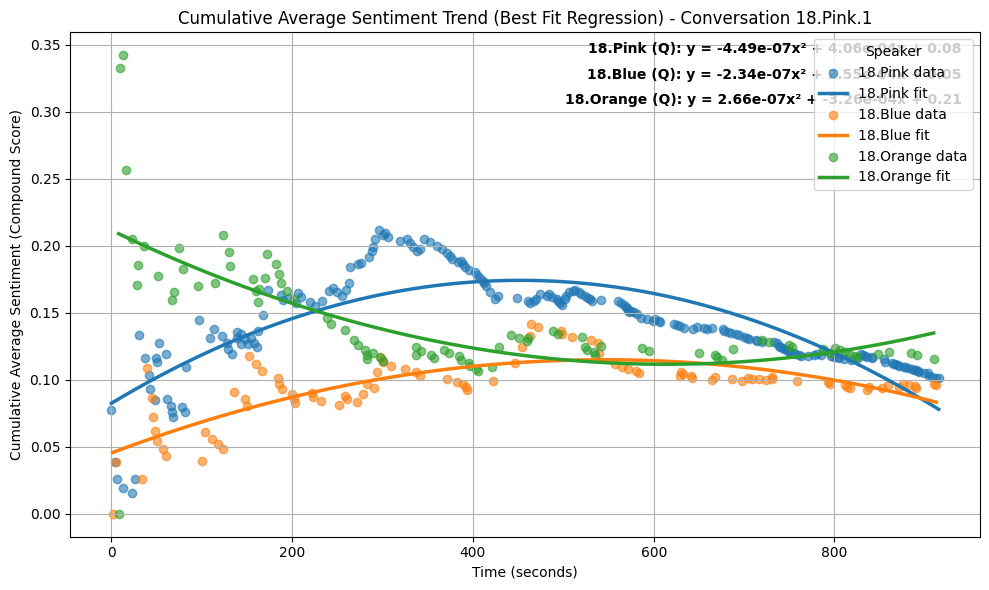

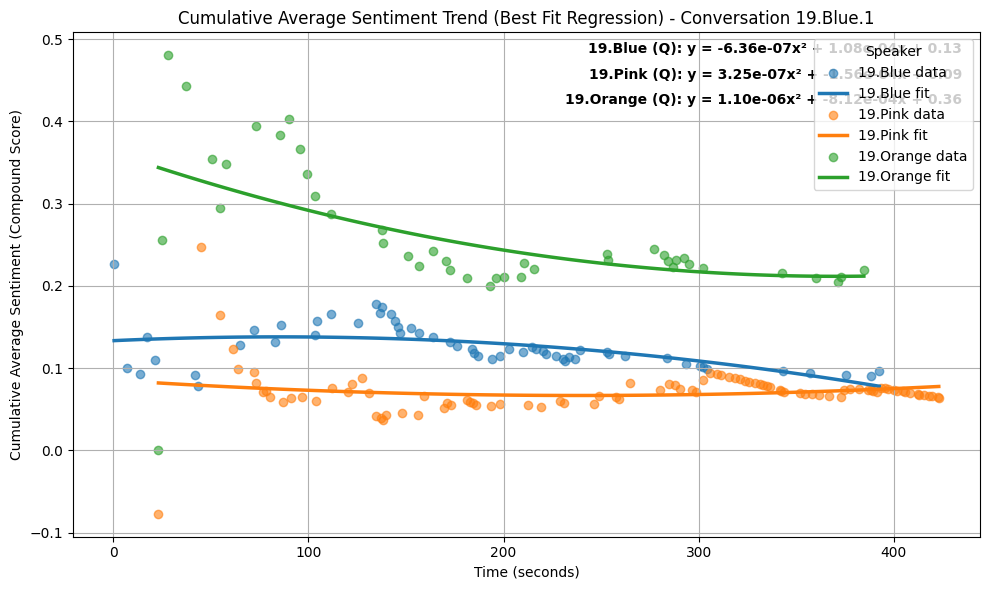

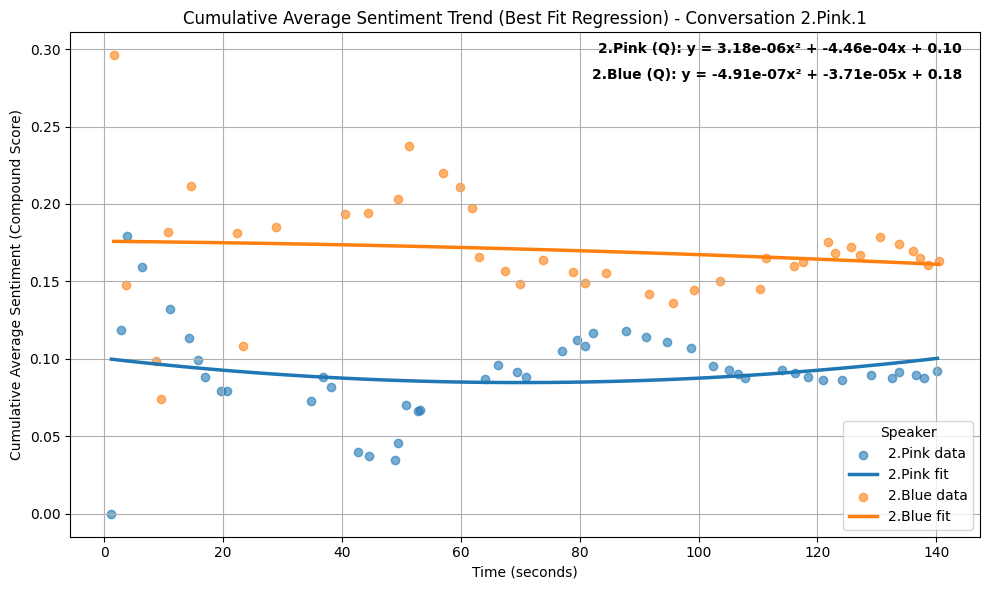

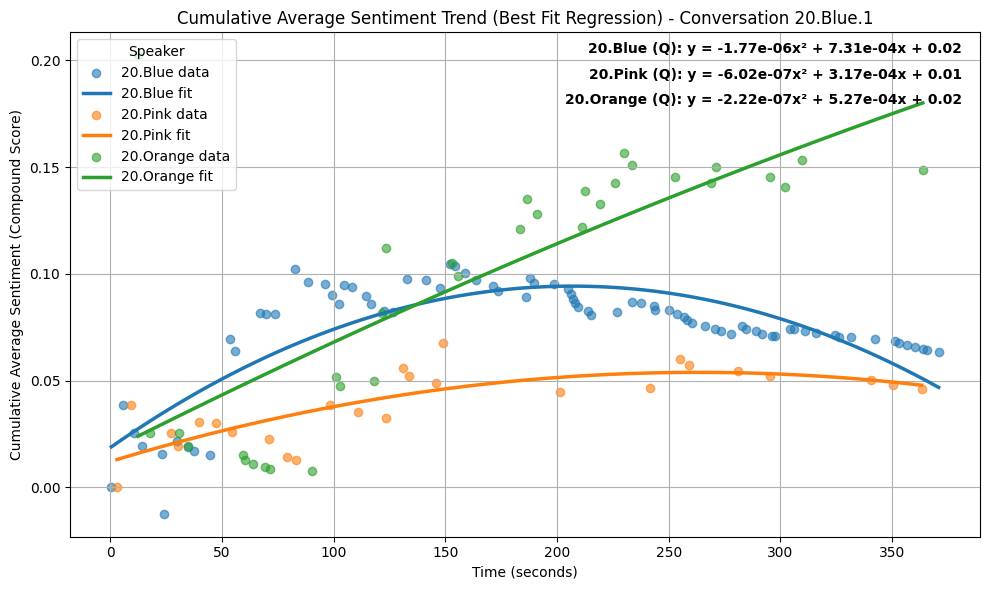

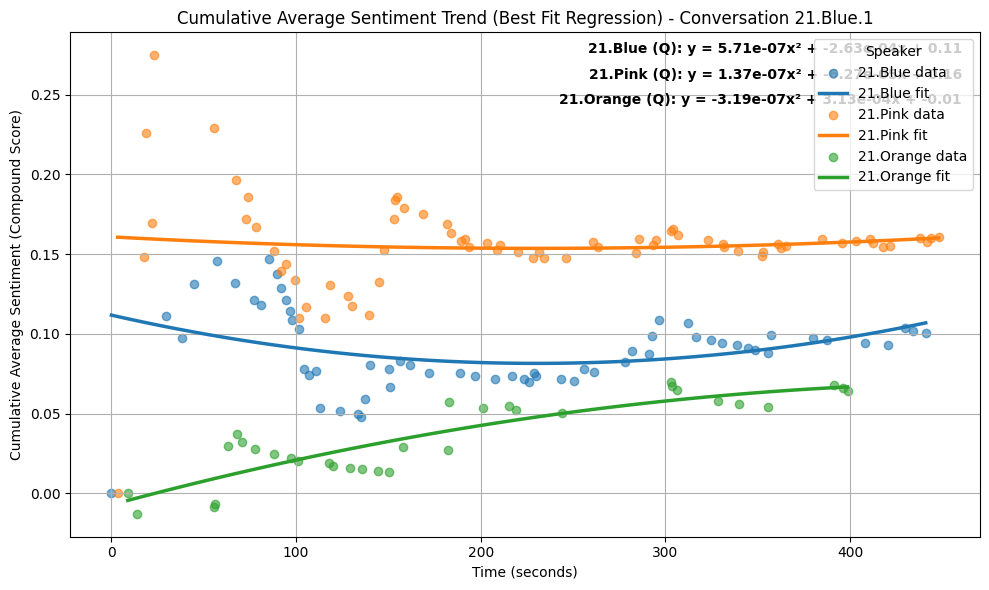

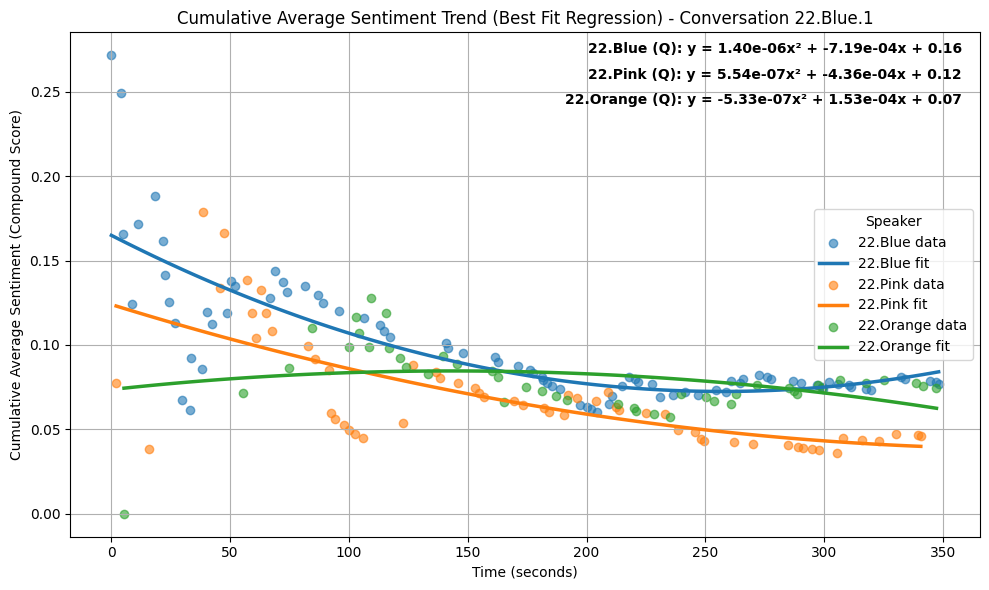

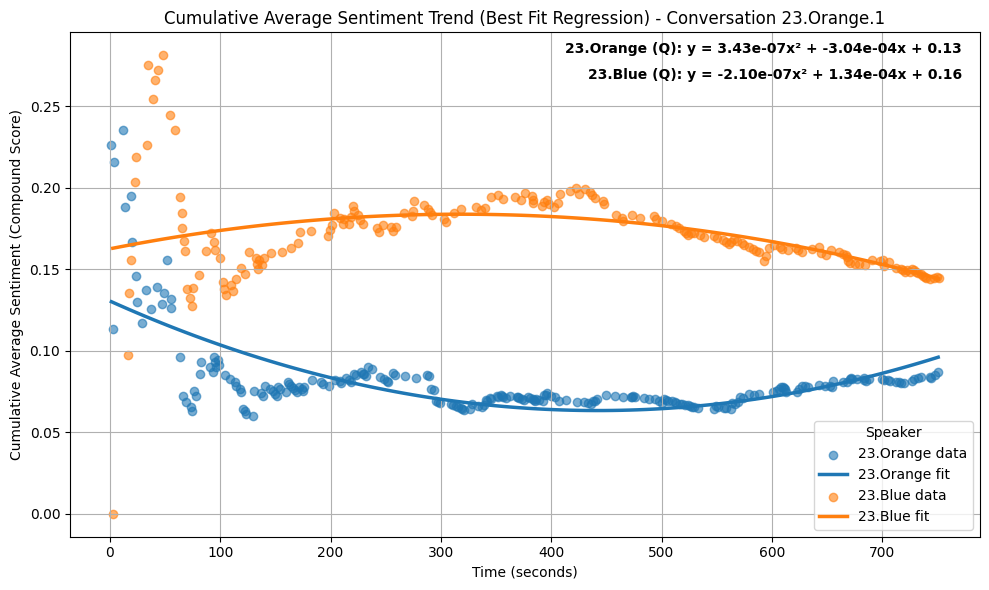

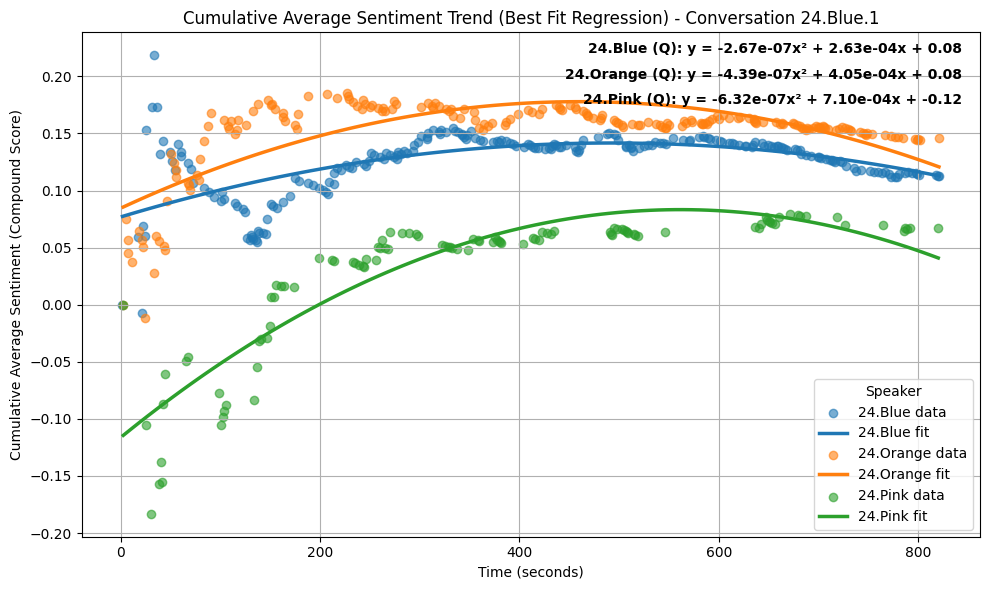

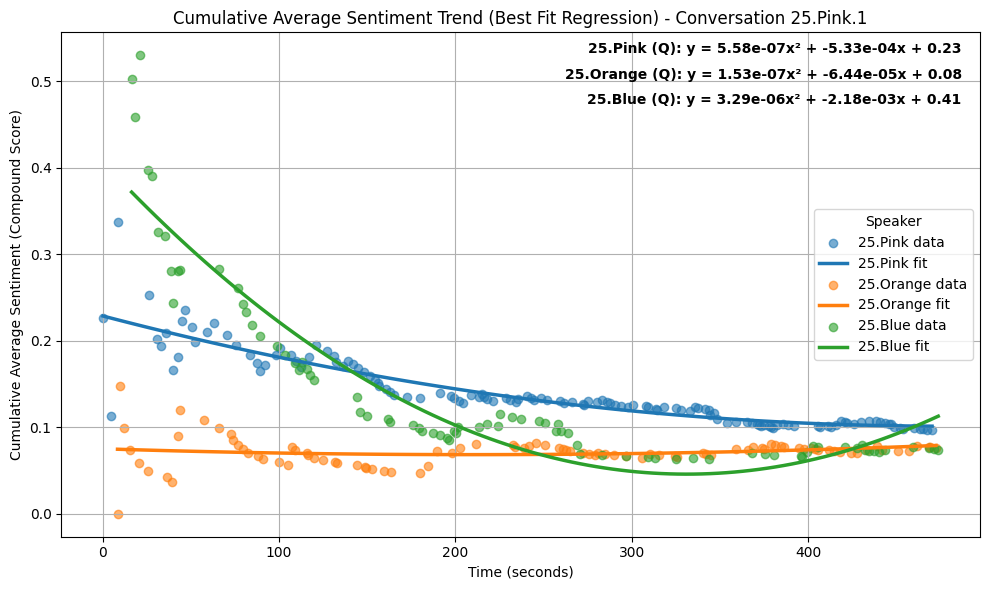

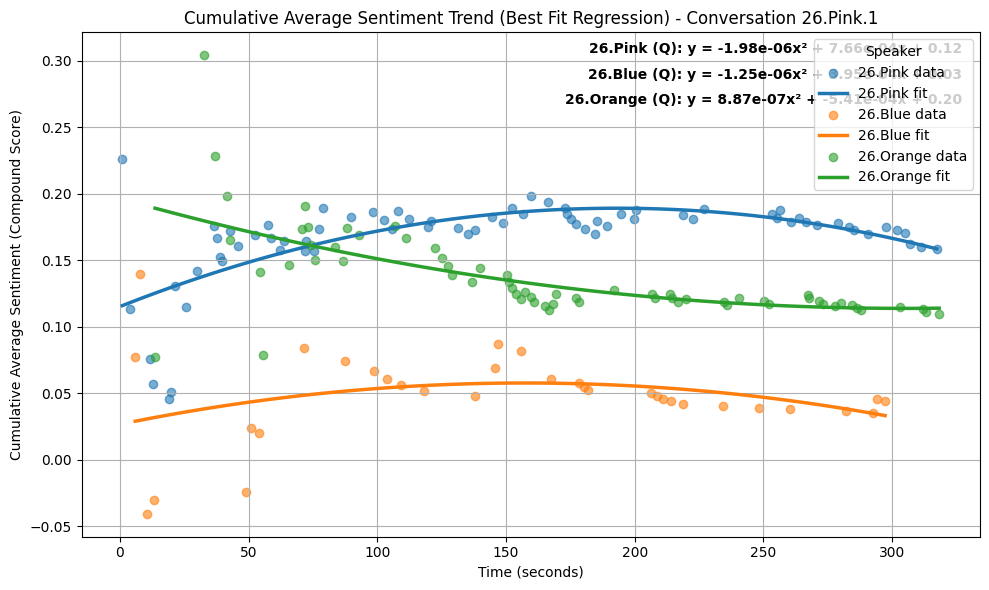

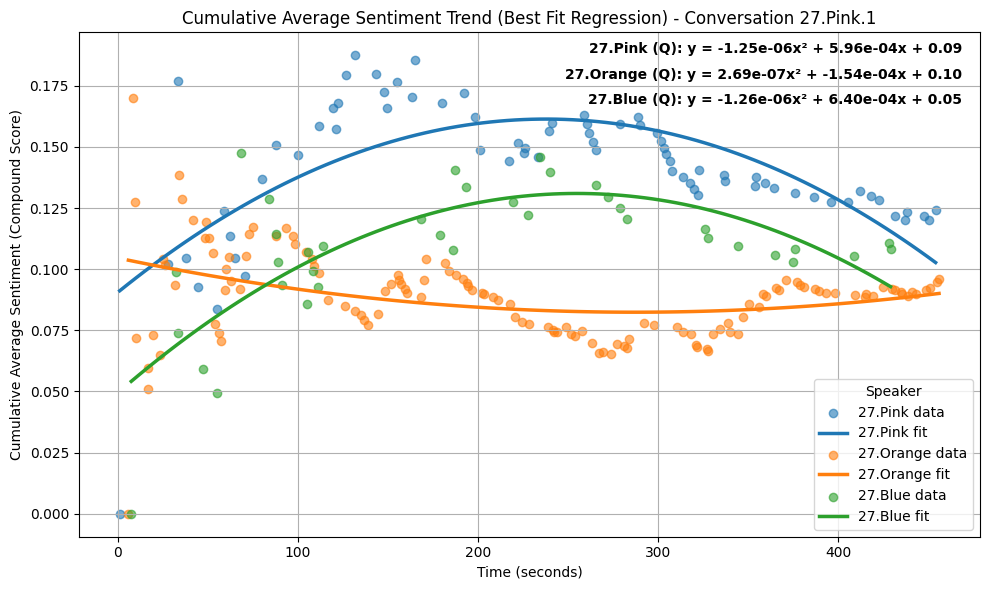

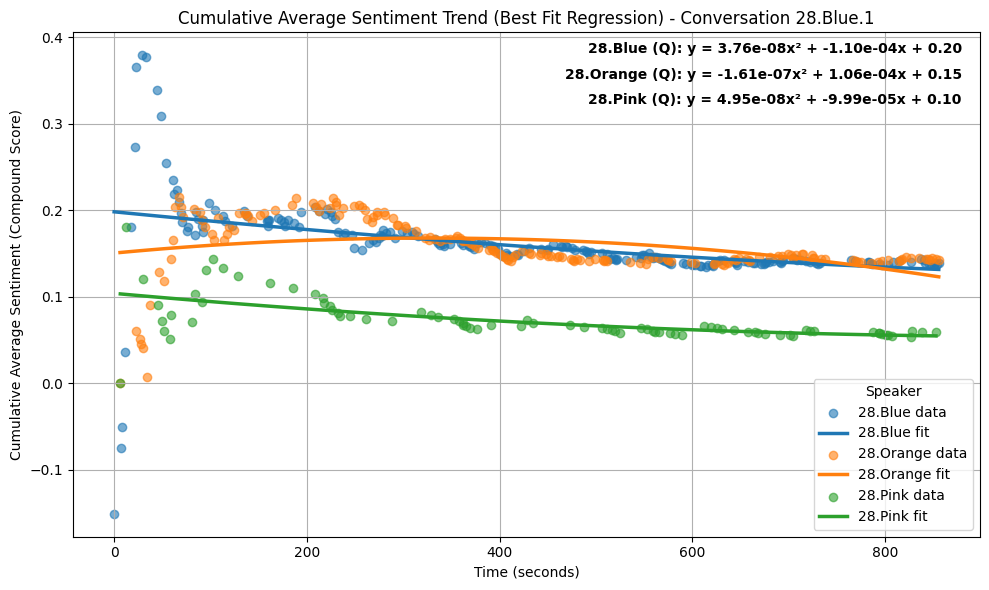

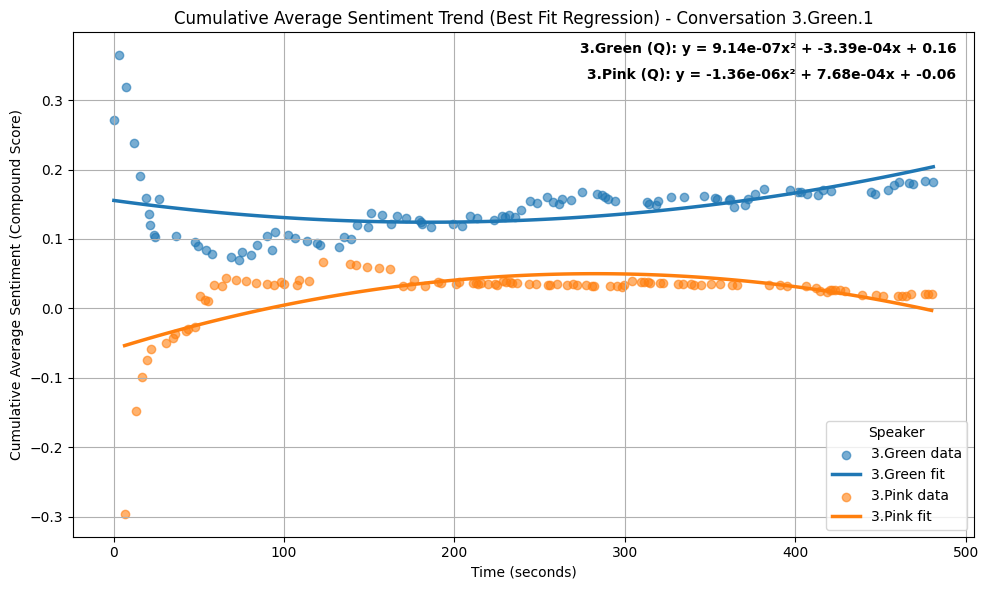

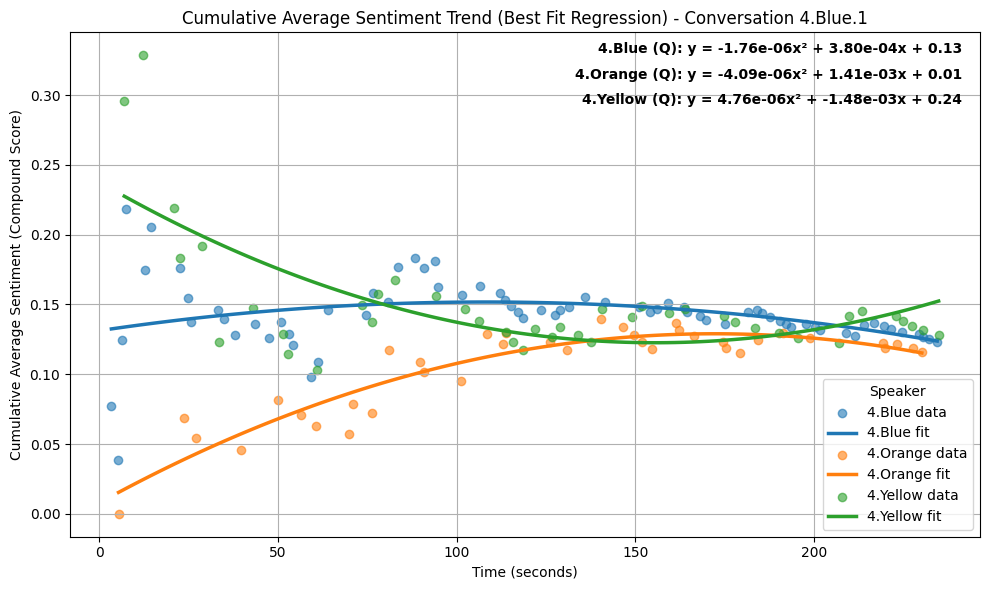

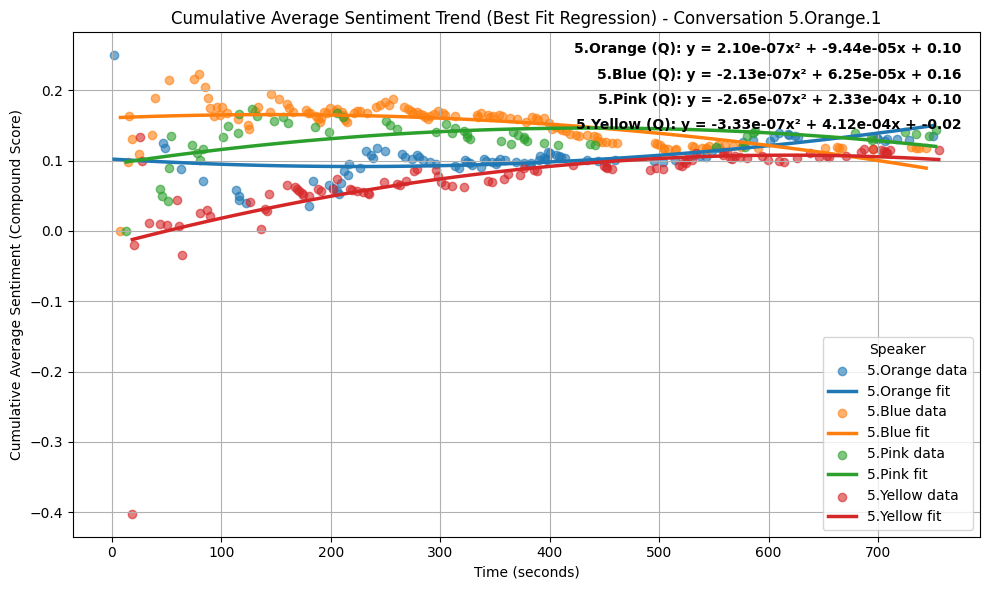

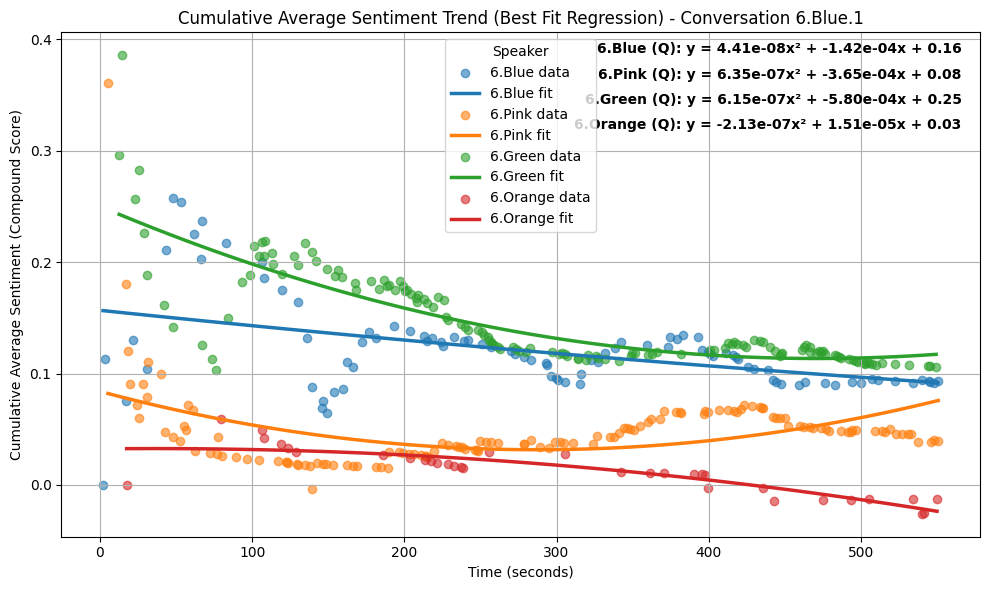

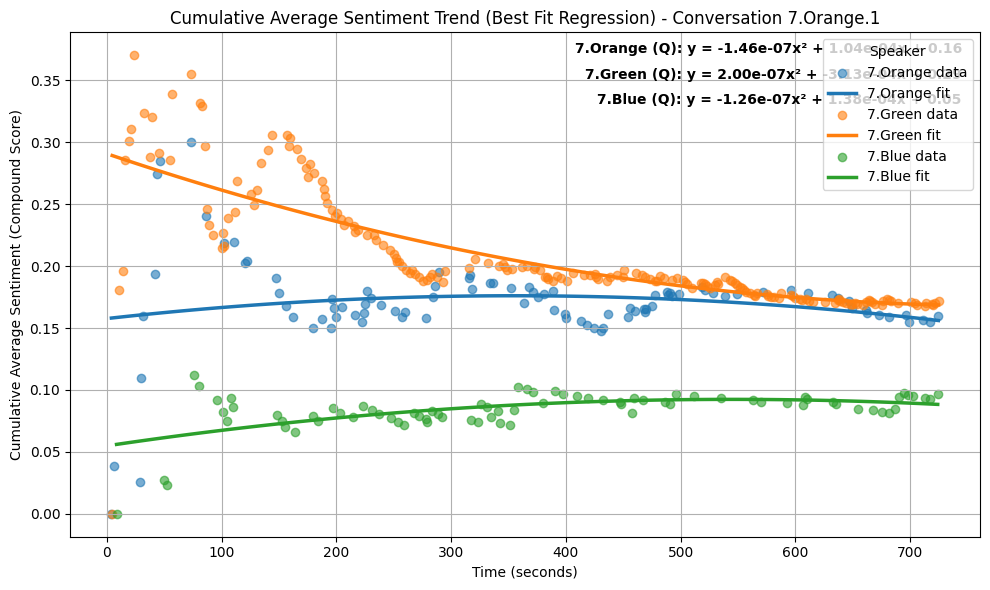

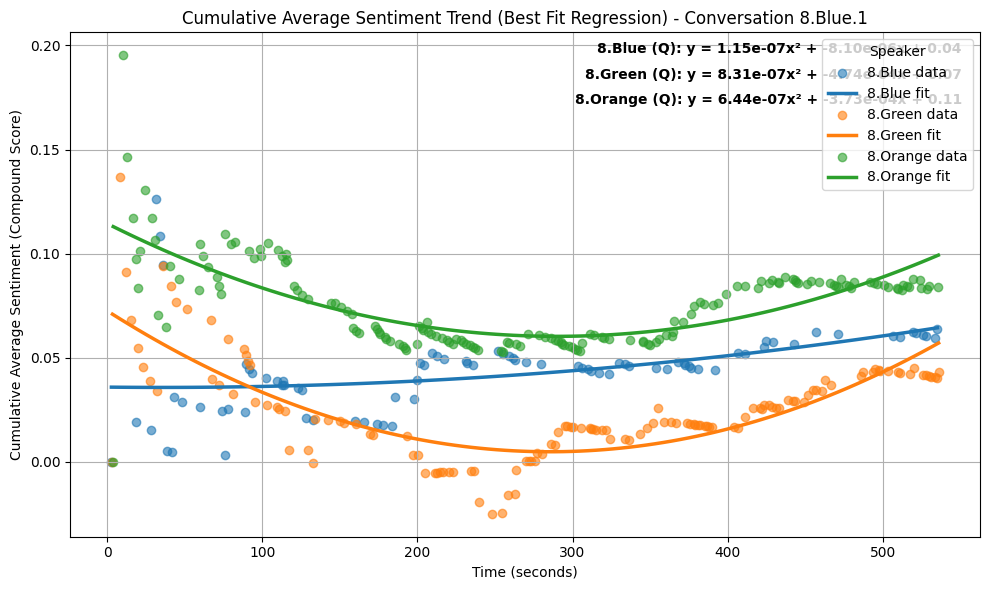

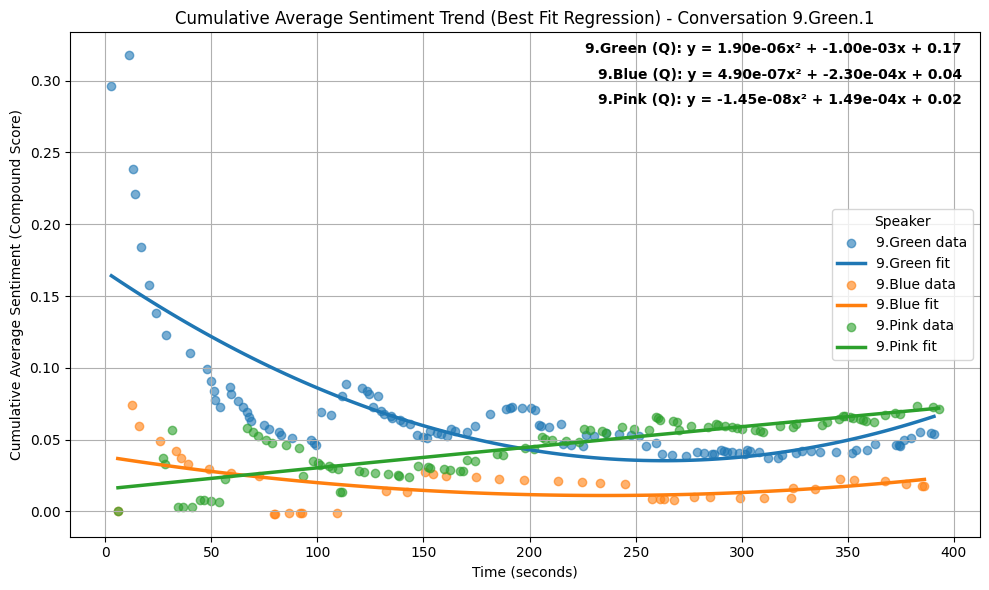

In [3]:
import matplotlib.pyplot as plt
import re
import numpy as np
from convokit import Corpus, download
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# instead of always using a straight linelike in previous code block, it fits both a linear and quadratic model, and chooses the one with less error.

nltk.download('vader_lexicon')

print("Downloading the GAP corpus...")
corpus = Corpus(filename=download("gap-corpus"))
print("Download complete!")

sia = SentimentIntensityAnalyzer()

def timestamp_to_seconds(timestamp_str):
    try:
        minutes, sec_dec = timestamp_str.split(":")
        return int(minutes) * 60 + float(sec_dec)
    except Exception as e:
        print(f"Error converting timestamp {timestamp_str}: {e}")
        return None

def collapse_consecutive_values(data_points):
    if not data_points:
        return data_points
    cleaned = []
    i = 0
    n = len(data_points)
    while i < n:
        cleaned.append(data_points[i])
        j = i + 1
        while j < n and np.isclose(data_points[j][1], data_points[i][1], atol=1e-8):
            j += 1
        i = j
    return cleaned

def best_fit_regression(x, y):
    # Linear regression (degree 1)
    lin_coef = np.polyfit(x, y, 1)
    lin_pred = np.polyval(lin_coef, x)
    lin_error = np.sum((y - lin_pred)**2)
    
    # Quadratic regression (degree 2)
    quad_coef = np.polyfit(x, y, 2)
    quad_pred = np.polyval(quad_coef, x)
    quad_error = np.sum((y - quad_pred)**2)
    
    if quad_error < lin_error:
        return "quadratic", quad_coef, quad_error
    else:
        return "linear", lin_coef, lin_error

# For each conversation, compute cumulative average sentiment and fit the best regression model.
for conv_id, conversation in corpus.conversations.items():
    speaker_sentiment_data = {}
    speaker_running_sentiment = {}
    
    utterances = list(conversation.iter_utterances())
    utterances.sort(key=lambda utt: timestamp_to_seconds(utt.timestamp) if utt.timestamp else 0)
    
    for utt in utterances:
        if not utt.timestamp or not utt.text:
            continue
        time_sec = timestamp_to_seconds(utt.timestamp)
        if time_sec is None:
            continue
        speaker_id = utt.speaker.id
        text = utt.text.strip()
        if not text:
            continue
        sentiment = sia.polarity_scores(text)['compound']
        if speaker_id not in speaker_running_sentiment:
            speaker_running_sentiment[speaker_id] = {'total_sentiment': 0.0, 'utterance_count': 0}
            speaker_sentiment_data[speaker_id] = []
        speaker_running_sentiment[speaker_id]['total_sentiment'] += sentiment
        speaker_running_sentiment[speaker_id]['utterance_count'] += 1
        avg_sentiment = speaker_running_sentiment[speaker_id]['total_sentiment'] / speaker_running_sentiment[speaker_id]['utterance_count']
        speaker_sentiment_data[speaker_id].append((time_sec, avg_sentiment))
    
    plt.figure(figsize=(10, 6))
    plt.title(f"Cumulative Average Sentiment Trend (Best Fit Regression) - Conversation {conv_id}")
    plt.xlabel("Time (seconds)")
    plt.ylabel("Cumulative Average Sentiment (Compound Score)")
    
    equation_texts = []
    
    for speaker_id, data_points in speaker_sentiment_data.items():
        data_points.sort(key=lambda x: x[0])
        cleaned_points = collapse_consecutive_values(data_points)
        times = np.array([pt[0] for pt in cleaned_points])
        sentiments = np.array([pt[1] for pt in cleaned_points])
        if len(times) < 2:
            continue
        
        model_type, coef, error = best_fit_regression(times, sentiments)
        reg_x = np.linspace(times.min(), times.max(), 100)
        if model_type == "linear":
            reg_y = coef[0] * reg_x + coef[1]
            eq_text = f"{speaker_id} (L): y = {coef[0]:.2e}x + {coef[1]:.2f}"
        else:
            reg_y = coef[0] * reg_x**2 + coef[1] * reg_x + coef[2]
            eq_text = f"{speaker_id} (Q): y = {coef[0]:.2e}x² + {coef[1]:.2e}x + {coef[2]:.2f}"
        
        plt.scatter(times, sentiments, label=f"{speaker_id} data", alpha=0.6)
        plt.plot(reg_x, reg_y, linewidth=2.5, label=f"{speaker_id} fit")
        equation_texts.append(eq_text)
    
    for i, eq in enumerate(equation_texts):
        plt.text(0.98, 0.98 - i * 0.05, eq,
                 transform=plt.gca().transAxes,
                 ha='right', va='top', fontweight='bold', fontsize=10)
    
    plt.legend(title="Speaker")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
